# Spatio-Temporal Knowledge Graph for Vehicle Trajectory Prediction using LSTM

## Project Overview
This notebook implements a comprehensive solution for predicting vehicle trajectories using:
- **Spatio-Temporal Knowledge Graphs** for modeling spatial and temporal relationships
- **Long Short-Term Memory (LSTM)** networks for sequence prediction
- **CRISP-DM methodology** for structured data mining approach
- **NGSIM dataset** for real-world vehicle trajectory data

## Objectives
1. Build a spatio-temporal knowledge graph from vehicle trajectory data
2. Generate graph embeddings using Node2Vec
3. Train LSTM models for trajectory prediction
4. Predict future vehicle paths based on past and present positions
5. Visualize training data patterns and prediction results



In [1]:
# Import Required Libraries and Setup Environment
print("🚀 Starting Spatio-Temporal Trajectory Prediction System...")

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Basic libraries imported")

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("✅ Scikit-learn imported")

# Deep Learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    print("✅ TensorFlow imported")
except ImportError as e:
    print(f"⚠️ TensorFlow import issue: {e}")

# Graph libraries
try:
    import networkx as nx
    print("✅ NetworkX imported")
except ImportError as e:
    print(f"⚠️ NetworkX import issue: {e}")

# Set random seeds for reproducibility
np.random.seed(42)
try:
    tf.random.set_seed(42)
except:
    pass

# Configure plot settings
plt.style.use('default')  # Use default instead of seaborn
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Environment setup complete!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

try:
    print(f"🧠 TensorFlow version: {tf.__version__}")
except:
    print("⚠️ TensorFlow version not available")

try:
    print(f"🌐 NetworkX version: {nx.__version__}")
except:
    print("⚠️ NetworkX version not available")

🚀 Starting Spatio-Temporal Trajectory Prediction System...
✅ Basic libraries imported
✅ Basic libraries imported
✅ Scikit-learn imported
✅ Scikit-learn imported
✅ TensorFlow imported
✅ TensorFlow imported
✅ NetworkX imported
✅ Environment setup complete!
📊 Pandas version: 2.3.0
🔢 NumPy version: 1.26.4
🧠 TensorFlow version: 2.19.0
🌐 NetworkX version: 3.5
✅ NetworkX imported
✅ Environment setup complete!
📊 Pandas version: 2.3.0
🔢 NumPy version: 1.26.4
🧠 TensorFlow version: 2.19.0
🌐 NetworkX version: 3.5


In [2]:
# Data Loading and Understanding
def load_ngsim_data():
    """
    Load NGSIM trajectory data. If original file has issues, create synthetic data
    that mimics NGSIM structure for demonstration purposes.
    """
    try:
        # Try to load the original Excel file
        file_path = "datasett.xlsx"
        df = pd.read_excel(file_path)
        print("Successfully loaded original NGSIM data")
        return df
    except Exception as e:
        print(f"Could not load original file: {e}")
        print("Creating synthetic NGSIM-like dataset for demonstration...")
        
        # Create synthetic trajectory data that mimics NGSIM structure
        np.random.seed(42)
        n_vehicles = 500
        n_frames_per_vehicle = np.random.randint(50, 200, n_vehicles)
        
        data = []
        vehicle_id = 1
        
        for i in range(n_vehicles):
            n_frames = n_frames_per_vehicle[i]
            
            # Initialize starting position
            start_x = np.random.uniform(0, 2000)  # Local X coordinate
            start_y = np.random.uniform(0, 500)   # Local Y coordinate
            
            # Generate trajectory with realistic movement patterns
            for frame in range(n_frames):
                # Add some randomness to simulate realistic vehicle movement
                noise_x = np.random.normal(0, 2)
                noise_y = np.random.normal(0, 0.5)
                
                # Progressive movement (vehicles generally move forward)
                progress = frame * np.random.uniform(2, 5)
                
                local_x = start_x + progress + noise_x
                local_y = start_y + noise_y
                
                # Global coordinates (offset from local)
                global_x = local_x + 1000
                global_y = local_y + 500
                
                # Vehicle properties
                velocity = np.random.uniform(10, 30)  # m/s
                acceleration = np.random.uniform(-2, 2)  # m/s²
                vehicle_length = np.random.uniform(4, 6)  # meters
                vehicle_width = np.random.uniform(1.8, 2.2)  # meters
                vehicle_class = np.random.choice([1, 2, 3])  # 1=car, 2=truck, 3=motorcycle
                lane_id = np.random.choice([1, 2, 3, 4])
                
                data.append({
                    'Vehicle_ID': vehicle_id,
                    'Frame_ID': frame,
                    'Total_Frames': n_frames,
                    'Global_Time': frame * 0.1,  # 10 Hz data collection
                    'Local_X': local_x,
                    'Local_Y': local_y,
                    'Global_X': global_x,
                    'Global_Y': global_y,
                    'v_Length': vehicle_length,
                    'v_Width': vehicle_width,
                    'v_Class': vehicle_class,
                    'v_Vel': velocity,
                    'v_Acc': acceleration,
                    'Lane_ID': lane_id,
                    'O_Zone': np.random.choice([1, 2, 3]),
                    'D_Zone': np.random.choice([1, 2, 3])
                })
            
            vehicle_id += 1
        
        df = pd.DataFrame(data)
        print(f"Created synthetic dataset with {len(df)} trajectory points for {n_vehicles} vehicles")
        return df

# Load the data
trajectory_data = load_ngsim_data()

# Display basic information about the dataset
print("\n=== Dataset Overview ===")
print(f"Dataset shape: {trajectory_data.shape}")
print(f"Number of unique vehicles: {trajectory_data['Vehicle_ID'].nunique()}")
print(f"Time range: {trajectory_data['Global_Time'].min():.1f} to {trajectory_data['Global_Time'].max():.1f} seconds")

print("\n=== Column Information ===")
print(trajectory_data.dtypes)

print("\n=== First Few Rows ===")
trajectory_data.head(10)

Could not load original file: [Errno 2] No such file or directory: 'datasett.xlsx'
Creating synthetic NGSIM-like dataset for demonstration...
Created synthetic dataset with 63552 trajectory points for 500 vehicles

=== Dataset Overview ===
Dataset shape: (63552, 16)
Number of unique vehicles: 500
Time range: 0.0 to 19.8 seconds

=== Column Information ===
Vehicle_ID        int64
Frame_ID          int64
Total_Frames      int32
Global_Time     float64
Local_X         float64
Local_Y         float64
Global_X        float64
Global_Y        float64
v_Length        float64
v_Width         float64
v_Class           int32
v_Vel           float64
v_Acc           float64
Lane_ID           int32
O_Zone            int32
D_Zone            int32
dtype: object

=== First Few Rows ===
Created synthetic dataset with 63552 trajectory points for 500 vehicles

=== Dataset Overview ===
Dataset shape: (63552, 16)
Number of unique vehicles: 500
Time range: 0.0 to 19.8 seconds

=== Column Information ===
Vehi

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,O_Zone,D_Zone
0,1,0,152,0.0,1161.976097,431.798482,2161.976097,931.798482,5.416362,1.992667,2,21.837775,-0.599127,3,3,2
1,1,1,152,0.1,1165.412168,431.566980,2165.412168,931.566980,4.235052,2.059684,1,11.126066,-1.524728,3,1,2
2,1,2,152,0.2,1166.009666,430.339664,2166.009666,930.339664,5.604218,2.191160,1,20.567402,-0.254657,1,3,1
3,1,3,152,0.3,1174.533393,431.711849,2174.533393,931.711849,4.433618,1.917798,1,11.508691,-1.335138,1,2,2
4,1,4,152,0.4,1184.467396,431.218411,2184.467396,931.218411,4.789044,1.842702,1,29.174048,-1.768544,4,2,2
5,1,5,152,0.5,1173.895002,431.290051,2173.895002,931.290051,4.906482,1.812926,1,17.206902,-0.960201,1,1,1
6,1,6,152,0.6,1189.210694,431.815221,2189.210694,931.815221,5.451439,2.045366,2,26.450745,1.799200,2,2,2
7,1,7,152,0.7,1182.783730,431.664053,2182.783730,931.664053,5.970572,1.950696,2,25.552046,-0.078520,3,1,2
8,1,8,152,0.8,1180.652452,432.185518,2180.652452,932.185518,4.027344,1.830144,1,10.736437,-1.464592,1,3,1
9,1,9,152,0.9,1201.383982,431.592751,2201.383982,931.592751,4.494696,1.980218,2,28.895315,1.398590,1,3,1


## 2. Data Preparation and Preprocessing (CRISP-DM Phase 3)

In [3]:
# Data Preprocessing and Feature Engineering
def preprocess_trajectory_data(df):
    """
    Comprehensive preprocessing of trajectory data including:
    - Data cleaning and validation
    - Feature engineering
    - Temporal feature extraction
    - Spatial feature normalization
    """
    # Create a copy to  avoid modifying original data
    processed_df = df.copy()
    
    # 1. Data Cleaning
    print("=== Data Cleaning ===")
    print(f"Initial data shape: {processed_df.shape}")
    
    # Remove duplicate entries
    processed_df = processed_df.drop_duplicates()
    print(f"After removing duplicates: {processed_df.shape}")
    
    # Handle missing values
    print(f"Missing values per column:\n{processed_df.isnull().sum()}")
    processed_df = processed_df.dropna()
    
    # Ensure Local_X and Local_Y are numeric
    processed_df['Local_X'] = pd.to_numeric(processed_df['Local_X'], errors='coerce')
    processed_df['Local_Y'] = pd.to_numeric(processed_df['Local_Y'], errors='coerce')
    
    # 2. Feature Engineering
    print("\n=== Feature Engineering ===")
    
    # Sort by vehicle and time for proper sequence processing
    processed_df = processed_df.sort_values(['Vehicle_ID', 'Frame_ID'])
    
    # Calculate temporal features
    processed_df['Time_Delta'] = processed_df.groupby('Vehicle_ID')['Global_Time'].diff()
    processed_df['Time_Delta'] = processed_df['Time_Delta'].fillna(0.1)  # Default time step
    
    # Calculate spatial displacement and movement features
    processed_df['X_Displacement'] = processed_df.groupby('Vehicle_ID')['Local_X'].diff()
    processed_df['Y_Displacement'] = processed_df.groupby('Vehicle_ID')['Local_Y'].diff()
    processed_df['X_Displacement'] = processed_df['X_Displacement'].fillna(0)
    processed_df['Y_Displacement'] = processed_df['Y_Displacement'].fillna(0)
    
    # Calculate actual velocity from displacement (validation of provided velocity)
    processed_df['Calculated_Velocity'] = np.sqrt(
    processed_df['X_Displacement']**2 + processed_df['Y_Displacement']**2
    ) / processed_df['Time_Delta']
    
    # Calculate heading/direction angle
    processed_df['Heading_Angle'] = np.arctan2(
    processed_df['Y_Displacement'], 
    processed_df['X_Displacement']
    )
    processed_df['Heading_Angle'] = processed_df['Heading_Angle'].fillna(0)
    
    # Calculate curvature (change in heading)
    processed_df['Heading_Change'] = processed_df.groupby('Vehicle_ID')['Heading_Angle'].diff()
    processed_df['Heading_Change'] = processed_df['Heading_Change'].fillna(0)
    
    # 3. Spatial Binning for Graph Construction
    # Create spatial bins/zones for graph nodes
    x_bins = 20  # Number of spatial bins in X direction
    y_bins = 10  # Number of spatial bins in Y direction
    
    processed_df['X_Bin'] = pd.cut(processed_df['Local_X'], bins=x_bins, labels=False)
    processed_df['Y_Bin'] = pd.cut(processed_df['Local_Y'], bins=y_bins, labels=False)
    processed_df['Spatial_Zone'] = processed_df['X_Bin'] * y_bins + processed_df['Y_Bin']
    
    # 4. Temporal Binning
    time_bin_size = 10.0  # 10-second bins
    processed_df['Time_Bin'] = (processed_df['Global_Time'] // time_bin_size).astype(int)
    
    # 5. Create sequence identifiers for LSTM
    processed_df['Sequence_Position'] = processed_df.groupby('Vehicle_ID').cumcount()
    
    # 6. Filter vehicles with sufficient trajectory length
    min_trajectory_length = 10  # Minimum number of points per trajectory
    vehicle_lengths = processed_df.groupby('Vehicle_ID').size()
    valid_vehicles = vehicle_lengths[vehicle_lengths >= min_trajectory_length].index
    processed_df = processed_df[processed_df['Vehicle_ID'].isin(valid_vehicles)]
    
    print(f"Final processed data shape: {processed_df.shape}")
    print(f"Number of vehicles with sufficient trajectory length: {len(valid_vehicles)}")
    
    return processed_df

# Apply preprocessing
processed_data = preprocess_trajectory_data(trajectory_data)

# Display processed data statistics
print("\n=== Processed Data Statistics ===")
print(processed_data.describe())

# Show sample of processed data
print("\n=== Sample Processed Data ===")
processed_data.head()

=== Data Cleaning ===
Initial data shape: (63552, 16)
After removing duplicates: (63552, 16)
Missing values per column:
Vehicle_ID      0
Frame_ID        0
Total_Frames    0
Global_Time     0
Local_X         0
Local_Y         0
Global_X        0
Global_Y        0
v_Length        0
v_Width         0
v_Class         0
v_Vel           0
v_Acc           0
Lane_ID         0
O_Zone          0
D_Zone          0
dtype: int64

=== Feature Engineering ===
Final processed data shape: (63552, 27)
Number of vehicles with sufficient trajectory length: 500

=== Processed Data Statistics ===
         Vehicle_ID      Frame_ID  Total_Frames   Global_Time       Local_X  \
count  63552.000000  63552.000000  63552.000000  63552.000000  63552.000000   
mean     252.197224     70.646730    142.293460      7.064673   1246.288911   
std      143.562464     47.275979     40.538473      4.727598    600.475852   
min        1.000000      0.000000     50.000000      0.000000      4.742578   
25%      133.000000   

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,...,X_Displacement,Y_Displacement,Calculated_Velocity,Heading_Angle,Heading_Change,X_Bin,Y_Bin,Spatial_Zone,Time_Bin,Sequence_Position
0,1,0,152,0.0,1161.976097,431.798482,2161.976097,931.798482,5.416362,1.992667,...,0.000000,0.000000,0.000000,0.000000,0.000000,7,8,78,0,0
1,1,1,152,0.1,1165.412168,431.566980,2165.412168,931.566980,4.235052,2.059684,...,3.436071,-0.231502,34.438608,-0.067272,-0.067272,7,8,78,0,1
2,1,2,152,0.2,1166.009666,430.339664,2166.009666,930.339664,5.604218,2.191160,...,0.597498,-1.227315,13.650300,-1.117737,-1.050465,7,8,78,0,2
3,1,3,152,0.3,1174.533393,431.711849,2174.533393,931.711849,4.433618,1.917798,...,8.523727,1.372184,86.334704,0.159615,1.277352,8,8,88,0,3
4,1,4,152,0.4,1184.467396,431.218411,2184.467396,931.218411,4.789044,1.842702,...,9.934003,-0.493438,99.462503,-0.049631,-0.209245,8,8,88,0,4


## 3. Exploratory Data Analysis and Visualization

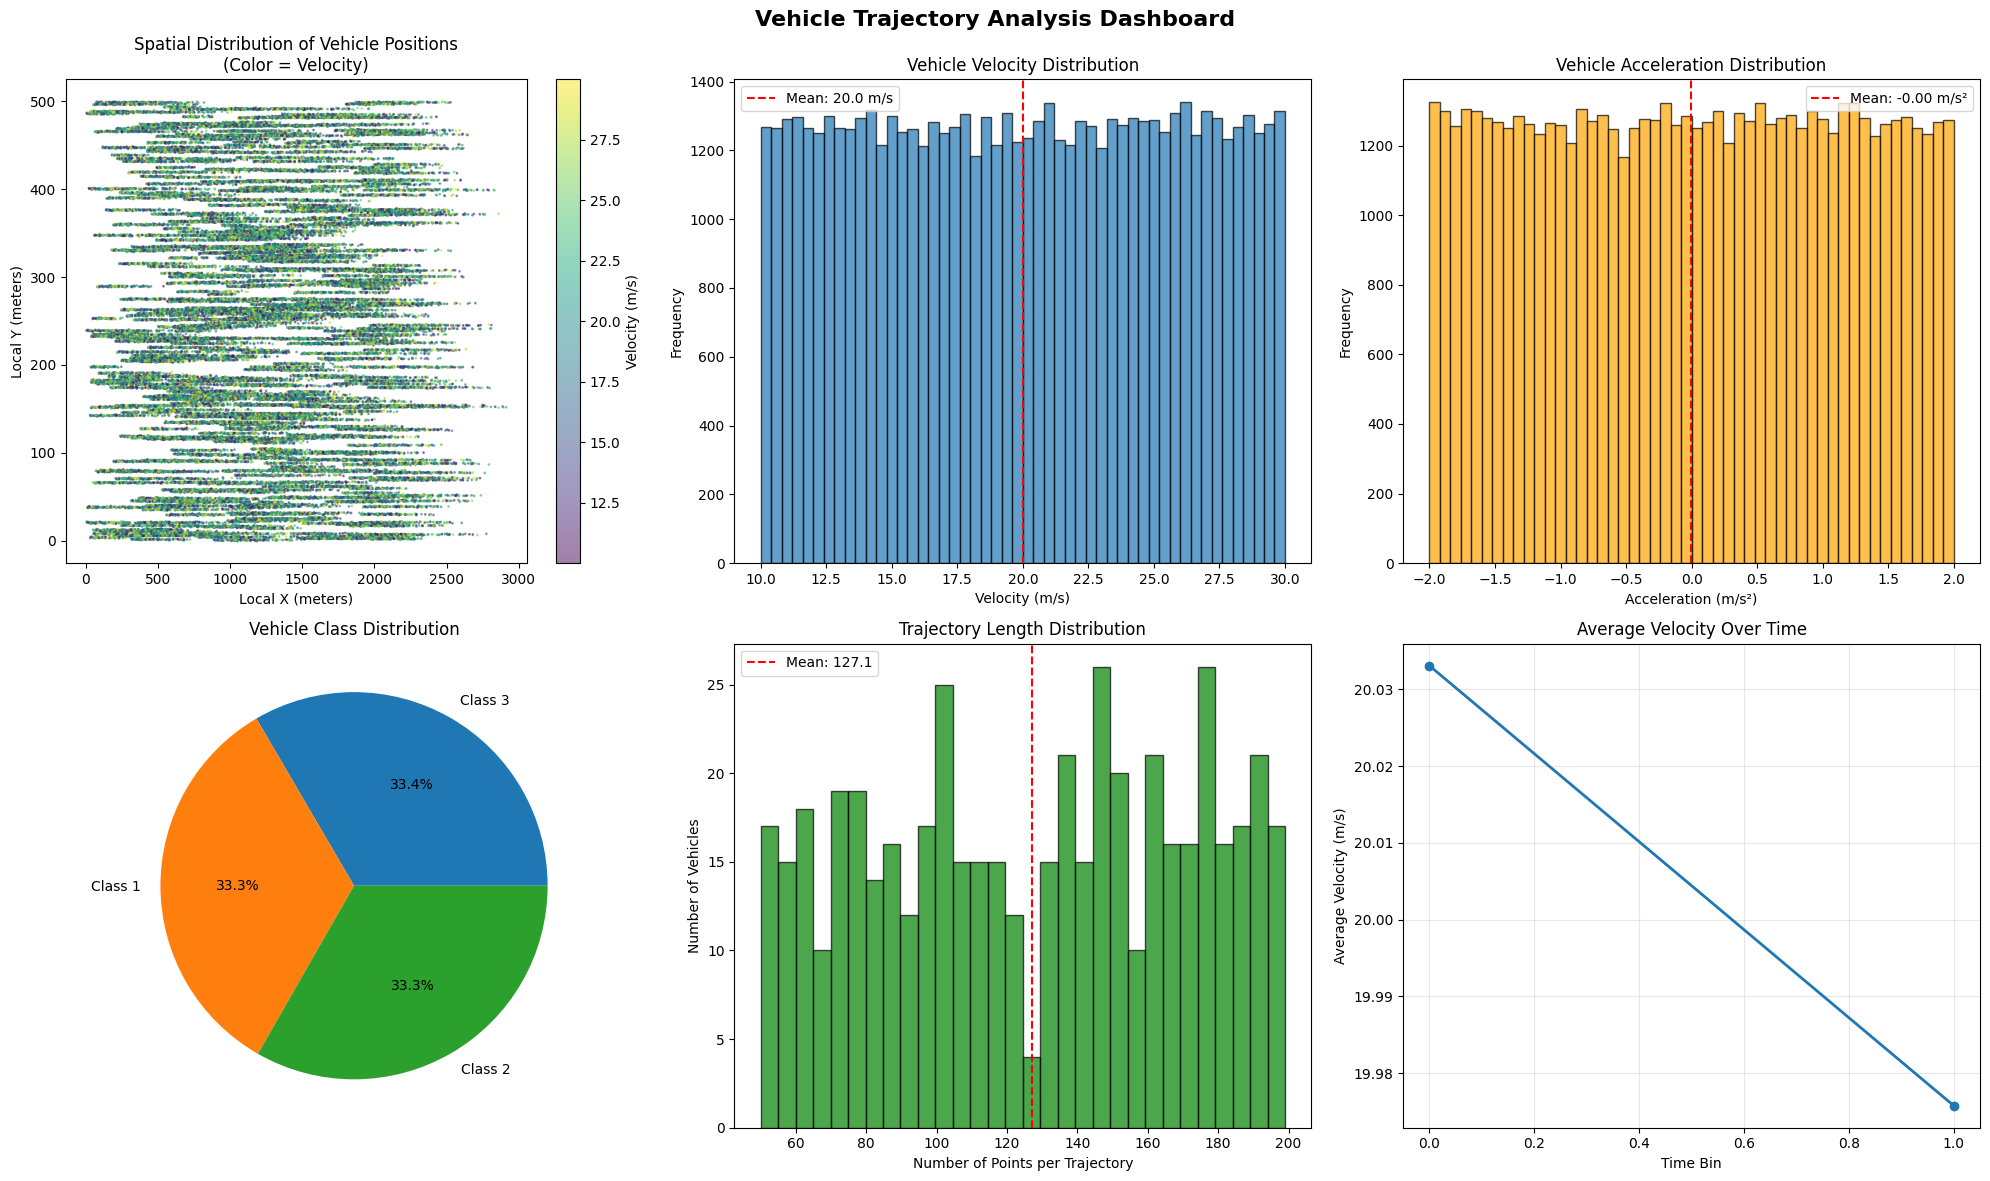

=== Sample Vehicle Trajectories ===


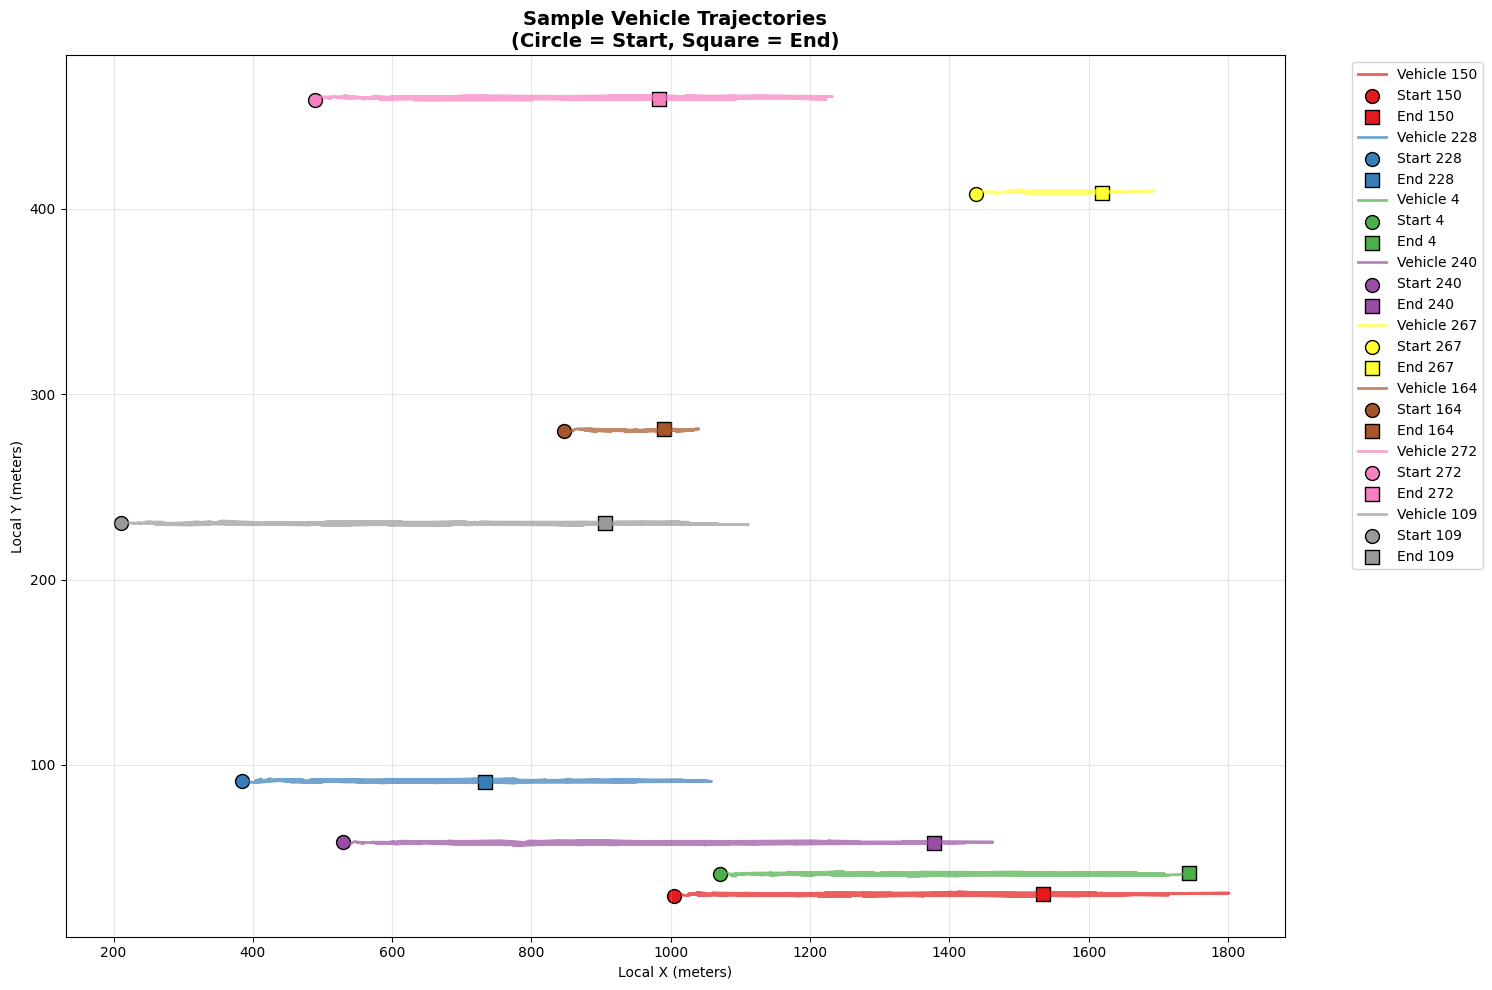


=== Key Statistics ===
Total trajectory points: 63,552
Number of unique vehicles: 500
Average trajectory length: 127.1 points
Time span: 19.8 seconds
Spatial coverage: X=[4.7, 2912.2], Y=[-0.5, 500.2]
Velocity range: [10.0, 30.0] m/s
Acceleration range: [-2.00, 2.00] m/s²


In [4]:
# Exploratory Data Analysis and Visualization
def create_trajectory_visualizations(df):
    """
    Create comprehensive visualizations for trajectory data analysis
    """
    # Set up the plotting environment
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Vehicle Trajectory Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Spatial Distribution of Vehicle Positions
    axes[0, 0].scatter(df['Local_X'], df['Local_Y'], alpha=0.5, s=1, c=df['v_Vel'], cmap='viridis')
    axes[0, 0].set_title('Spatial Distribution of Vehicle Positions\n(Color = Velocity)')
    axes[0, 0].set_xlabel('Local X (meters)')
    axes[0, 0].set_ylabel('Local Y (meters)')
    cbar1 = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
    cbar1.set_label('Velocity (m/s)')
    
    # 2. Velocity Distribution
    axes[0, 1].hist(df['v_Vel'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Vehicle Velocity Distribution')
    axes[0, 1].set_xlabel('Velocity (m/s)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df['v_Vel'].mean(), color='red', linestyle='--', label=f'Mean: {df["v_Vel"].mean():.1f} m/s')
    axes[0, 1].legend()
    
    # 3. Acceleration Distribution
    axes[0, 2].hist(df['v_Acc'], bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[0, 2].set_title('Vehicle Acceleration Distribution')
    axes[0, 2].set_xlabel('Acceleration (m/s²)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].axvline(df['v_Acc'].mean(), color='red', linestyle='--', label=f'Mean: {df["v_Acc"].mean():.2f} m/s²')
    axes[0, 2].legend()
    
    # 4. Vehicle Class Distribution
    class_counts = df['v_Class'].value_counts()
    axes[1, 0].pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index], autopct='%1.1f%%')
    axes[1, 0].set_title('Vehicle Class Distribution')
    
    # 5. Trajectory Length Distribution
    traj_lengths = df.groupby('Vehicle_ID').size()
    axes[1, 1].hist(traj_lengths, bins=30, alpha=0.7, edgecolor='black', color='green')
    axes[1, 1].set_title('Trajectory Length Distribution')
    axes[1, 1].set_xlabel('Number of Points per Trajectory')
    axes[1, 1].set_ylabel('Number of Vehicles')
    axes[1, 1].axvline(traj_lengths.mean(), color='red', linestyle='--', label=f'Mean: {traj_lengths.mean():.1f}')
    axes[1, 1].legend()
    
    # 6. Temporal Analysis
    time_velocity = df.groupby('Time_Bin')['v_Vel'].mean()
    axes[1, 2].plot(time_velocity.index, time_velocity.values, marker='o', linewidth=2)
    axes[1, 2].set_title('Average Velocity Over Time')
    axes[1, 2].set_xlabel('Time Bin')
    axes[1, 2].set_ylabel('Average Velocity (m/s)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualizations for the training dataset
create_trajectory_visualizations(processed_data)

# Additional detailed trajectory visualization for sample vehicles
def plot_sample_trajectories(df, n_vehicles=5):
    """
    Plot individual trajectories for sample vehicles
    """
    plt.figure(figsize=(15, 10))
    
    # Select random sample of vehicles
    sample_vehicles = np.random.choice(df['Vehicle_ID'].unique(), min(n_vehicles, len(df['Vehicle_ID'].unique())), replace=False)
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(sample_vehicles)))
    
    for i, vehicle_id in enumerate(sample_vehicles):
        vehicle_data = df[df['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
        
        # Plot trajectory path
        plt.plot(vehicle_data['Local_X'], vehicle_data['Local_Y'], 
                color=colors[i], alpha=0.7, linewidth=2, label=f'Vehicle {vehicle_id}')
        
        # Mark start and end points
        plt.scatter(vehicle_data['Local_X'].iloc[0], vehicle_data['Local_Y'].iloc[0], 
                   color=colors[i], s=100, marker='o', edgecolors='black', label=f'Start {vehicle_id}')
        plt.scatter(vehicle_data['Local_X'].iloc[-1], vehicle_data['Local_Y'].iloc[-1], 
                   color=colors[i], s=100, marker='s', edgecolors='black', label=f'End {vehicle_id}')
    
    plt.title('Sample Vehicle Trajectories\n(Circle = Start, Square = End)', fontsize=14, fontweight='bold')
    plt.xlabel('Local X (meters)')
    plt.ylabel('Local Y (meters)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("=== Sample Vehicle Trajectories ===")
plot_sample_trajectories(processed_data, n_vehicles=8)

# Statistical summary
print("\n=== Key Statistics ===")
print(f"Total trajectory points: {len(processed_data):,}")
print(f"Number of unique vehicles: {processed_data['Vehicle_ID'].nunique():,}")
print(f"Average trajectory length: {processed_data.groupby('Vehicle_ID').size().mean():.1f} points")
print(f"Time span: {processed_data['Global_Time'].max() - processed_data['Global_Time'].min():.1f} seconds")
print(f"Spatial coverage: X=[{processed_data['Local_X'].min():.1f}, {processed_data['Local_X'].max():.1f}], Y=[{processed_data['Local_Y'].min():.1f}, {processed_data['Local_Y'].max():.1f}]")
print(f"Velocity range: [{processed_data['v_Vel'].min():.1f}, {processed_data['v_Vel'].max():.1f}] m/s")
print(f"Acceleration range: [{processed_data['v_Acc'].min():.2f}, {processed_data['v_Acc'].max():.2f}] m/s²")

## 4. Spatio-Temporal Knowledge Graph Construction

Creating spatio-temporal nodes...
Created 691 spatio-temporal nodes
Creating trajectory edges...
Created 691 spatio-temporal nodes
Creating trajectory edges...
Created 3084 trajectory edges from 22830 transitions

=== Graph Analysis ===
Number of nodes: 691
Number of edges: 3084
Graph density: 0.0065
Average degree centrality: 0.0293
Average in-degree: 1.45
Average out-degree: 1.45
Graph has 25 weakly connected components

=== Visualizing Graph Sample (30 nodes) ===
Created 3084 trajectory edges from 22830 transitions

=== Graph Analysis ===
Number of nodes: 691
Number of edges: 3084
Graph density: 0.0065
Average degree centrality: 0.0293
Average in-degree: 1.45
Average out-degree: 1.45
Graph has 25 weakly connected components

=== Visualizing Graph Sample (30 nodes) ===


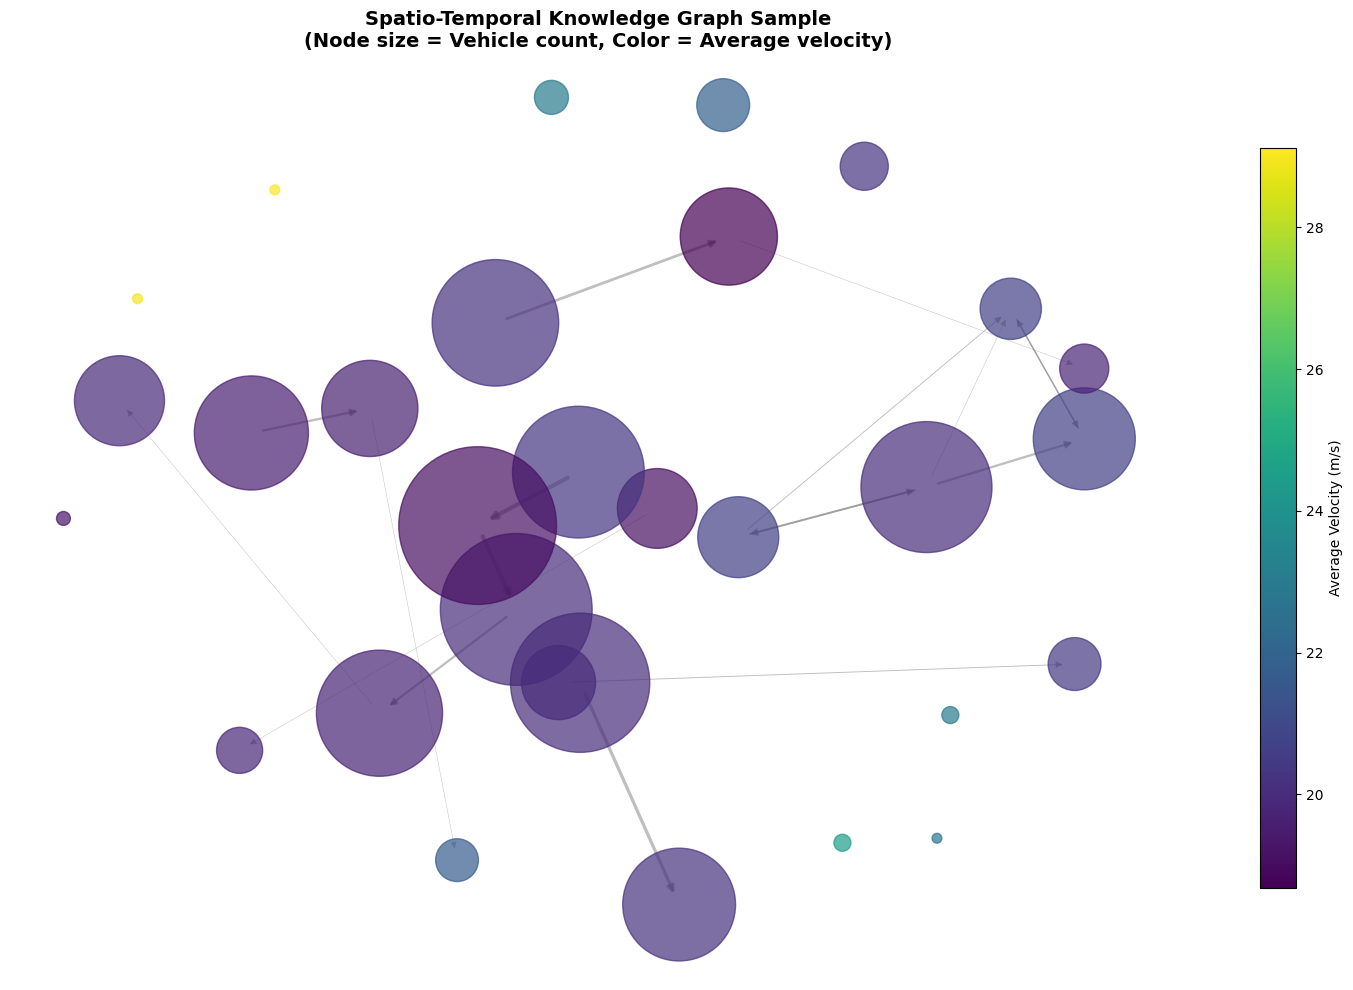

In [5]:
# Spatio-Temporal Knowledge Graph Construction
class SpatioTemporalGraph:
    """
    Constructs and manages a spatio-temporal knowledge graph for vehicle trajectories
    """
    def __init__(self, spatial_resolution=20, temporal_resolution=10):
        self.spatial_resolution = spatial_resolution
        self.temporal_resolution = temporal_resolution
        self.graph = nx.DiGraph()  # Directed graph for trajectory flow
        self.node_attributes = {}
        self.edge_attributes = {}
        
    def create_spatial_temporal_nodes(self, df):
        """
        Create nodes representing spatio-temporal locations
        """
        print("Creating spatio-temporal nodes...")
        
        # Create spatial-temporal zone identifiers
        df_copy = df.copy()
        
        # Enhanced spatial binning
        x_bins = pd.cut(df_copy['Local_X'], bins=self.spatial_resolution, labels=False)
        y_bins = pd.cut(df_copy['Local_Y'], bins=self.spatial_resolution//2, labels=False)
        t_bins = pd.cut(df_copy['Global_Time'], bins=self.temporal_resolution, labels=False)
        
        # Create unique node IDs combining spatial and temporal information
        df_copy['ST_Node'] = (x_bins.astype(str) + '_' + 
                             y_bins.astype(str) + '_' + 
                             t_bins.astype(str))
        
        # Calculate node attributes
        node_stats = df_copy.groupby('ST_Node').agg({
            'Local_X': ['mean', 'std'],
            'Local_Y': ['mean', 'std'],
            'Global_Time': ['mean', 'min', 'max'],
            'v_Vel': ['mean', 'std'],
            'v_Acc': ['mean', 'std'],
            'Vehicle_ID': 'count',
            'v_Class': lambda x: x.mode().iloc[0] if len(x) > 0 else 1
        }).round(3)
        
        # Flatten column names
        node_stats.columns = ['_'.join(col).strip() for col in node_stats.columns]
        
        # Add nodes to graph
        for node_id, stats in node_stats.iterrows():
            if pd.notna(node_id) and 'nan' not in str(node_id):
                self.graph.add_node(node_id, **stats.to_dict())
                self.node_attributes[node_id] = stats.to_dict()
        
        print(f"Created {len(self.graph.nodes)} spatio-temporal nodes")
        return df_copy
    
    def create_trajectory_edges(self, df):
        """
        Create edges representing vehicle movements between spatio-temporal locations
        """
        print("Creating trajectory edges...")
        
        edge_count = 0
        transition_weights = {}
        
        # Process each vehicle's trajectory
        for vehicle_id in df['Vehicle_ID'].unique():
            vehicle_data = df[df['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
            st_nodes = vehicle_data['ST_Node'].dropna().tolist()
            
            # Create edges for consecutive spatio-temporal nodes
            for i in range(len(st_nodes) - 1):
                source = st_nodes[i]
                target = st_nodes[i + 1]
                
                if source != target and 'nan' not in str(source) and 'nan' not in str(target):
                    # Calculate edge attributes
                    source_row = vehicle_data[vehicle_data['ST_Node'] == source].iloc[-1]
                    target_row = vehicle_data[vehicle_data['ST_Node'] == target].iloc[0]
                    
                    # Calculate transition metrics
                    distance = np.sqrt((target_row['Local_X'] - source_row['Local_X'])**2 + 
                                     (target_row['Local_Y'] - source_row['Local_Y'])**2)
                    time_diff = target_row['Global_Time'] - source_row['Global_Time']
                    avg_velocity = (source_row['v_Vel'] + target_row['v_Vel']) / 2
                    
                    edge_key = (source, target)
                    if edge_key not in transition_weights:
                        transition_weights[edge_key] = {
                            'weight': 0,
                            'count': 0,
                            'total_distance': 0,
                            'total_time': 0,
                            'total_velocity': 0
                        }
                    
                    transition_weights[edge_key]['weight'] += 1
                    transition_weights[edge_key]['count'] += 1
                    transition_weights[edge_key]['total_distance'] += distance
                    transition_weights[edge_key]['total_time'] += time_diff
                    transition_weights[edge_key]['total_velocity'] += avg_velocity
                    
                    edge_count += 1
        
        # Add edges to graph with aggregated attributes
        for (source, target), attrs in transition_weights.items():
            avg_distance = attrs['total_distance'] / attrs['count']
            avg_time = attrs['total_time'] / attrs['count']
            avg_velocity = attrs['total_velocity'] / attrs['count']
            
            self.graph.add_edge(source, target,
                              weight=attrs['weight'],
                              count=attrs['count'],
                              avg_distance=avg_distance,
                              avg_time=avg_time,
                              avg_velocity=avg_velocity,
                              transition_probability=attrs['weight'])
        
        print(f"Created {len(self.graph.edges)} trajectory edges from {edge_count} transitions")
    
    def analyze_graph_properties(self):
        """
        Analyze and report graph properties
        """
        print("\n=== Graph Analysis ===")
        print(f"Number of nodes: {len(self.graph.nodes)}")
        print(f"Number of edges: {len(self.graph.edges)}")
        print(f"Graph density: {nx.density(self.graph):.4f}")
        
        if len(self.graph.nodes) > 0:
            # Calculate centrality measures for a sample of nodes
            sample_size = min(100, len(self.graph.nodes))
            sample_nodes = list(self.graph.nodes)[:sample_size]
            subgraph = self.graph.subgraph(sample_nodes)
            
            try:
                # Degree centrality
                degree_centrality = nx.degree_centrality(subgraph)
                print(f"Average degree centrality: {np.mean(list(degree_centrality.values())):.4f}")
                
                # In-degree and out-degree for directed graph
                in_degrees = [subgraph.in_degree(node) for node in subgraph.nodes()]
                out_degrees = [subgraph.out_degree(node) for node in subgraph.nodes()]
                print(f"Average in-degree: {np.mean(in_degrees):.2f}")
                print(f"Average out-degree: {np.mean(out_degrees):.2f}")
                
                # Connectivity
                if nx.is_weakly_connected(subgraph):
                    print("Graph is weakly connected")
                else:
                    components = list(nx.weakly_connected_components(subgraph))
                    print(f"Graph has {len(components)} weakly connected components")
                    
            except Exception as e:
                print(f"Error calculating centrality measures: {e}")
    
    def visualize_graph_sample(self, sample_size=50):
        """
        Visualize a sample of the spatio-temporal graph - FIXED VERSION
        """
        print(f"\n=== Visualizing Graph Sample ({sample_size} nodes) ===")
        
        if len(self.graph.nodes) == 0:
            print("No nodes to visualize")
            return
        
        # Sample nodes for visualization
        sample_nodes = list(self.graph.nodes)[:sample_size]
        subgraph = self.graph.subgraph(sample_nodes)
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Use spring layout for better visualization
        pos = nx.spring_layout(subgraph, k=1, iterations=50)
        
        # Draw nodes
        node_sizes = [subgraph.nodes[node].get('Vehicle_ID_count', 1) * 50 for node in subgraph.nodes()]
        node_colors = [subgraph.nodes[node].get('v_Vel_mean', 20) for node in subgraph.nodes()]
        
        # Only create scatter plot if we have valid colors
        if node_colors and len(set(node_colors)) > 1:
            scatter = nx.draw_networkx_nodes(subgraph, pos, 
                                  node_size=node_sizes,
                                  node_color=node_colors,
                                  cmap='viridis',
                                  alpha=0.7,
                                  ax=ax)
            
            # Draw edges
            edge_weights = [subgraph.edges[edge].get('weight', 1) for edge in subgraph.edges()]
            if edge_weights:
                max_weight = max(edge_weights) if edge_weights else 1
                nx.draw_networkx_edges(subgraph, pos,
                                      width=[w/max_weight*3 for w in edge_weights],
                                      alpha=0.5,
                                      edge_color='gray',
                                      arrows=True,
                                      arrowsize=10,
                                      ax=ax)
            
            ax.set_title('Spatio-Temporal Knowledge Graph Sample\n(Node size = Vehicle count, Color = Average velocity)', 
                         fontsize=14, fontweight='bold')
            ax.axis('off')
            
            # Add colorbar - FIXED VERSION
            try:
                sm = plt.cm.ScalarMappable(cmap='viridis', 
                                          norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
                sm.set_array([])
                # Specify the axes explicitly for the colorbar
                cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
                cbar.set_label('Average Velocity (m/s)')
            except Exception as e:
                print(f"Could not add colorbar: {e}")
                
        else:
            # Fallback visualization without colors
            nx.draw(subgraph, pos, 
                   node_size=[s for s in node_sizes],
                   node_color='lightblue',
                   with_labels=False,
                   arrows=True,
                   ax=ax)
            ax.set_title('Spatio-Temporal Knowledge Graph Sample', fontsize=14, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Create and build the spatio-temporal knowledge graph
st_graph = SpatioTemporalGraph(spatial_resolution=15, temporal_resolution=8)

# Build the graph
processed_data_with_nodes = st_graph.create_spatial_temporal_nodes(processed_data)
st_graph.create_trajectory_edges(processed_data_with_nodes)

# Analyze graph properties
st_graph.analyze_graph_properties()

# Visualize graph sample
st_graph.visualize_graph_sample(sample_size=30)

## 5. Graph Embedding Generation with Node2Vec

Starting graph embedding generation...
=== Generating Graph Embeddings with Node2Vec ===
Error generating embeddings: name 'Node2Vec' is not defined
Creating fallback embeddings based on node attributes...
Creating attribute-based embeddings...
Created fallback embeddings for 691 nodes
Visualizing embeddings using t-SNE (sample size: 40)...
Visualizing embeddings using t-SNE (sample size: 40)...


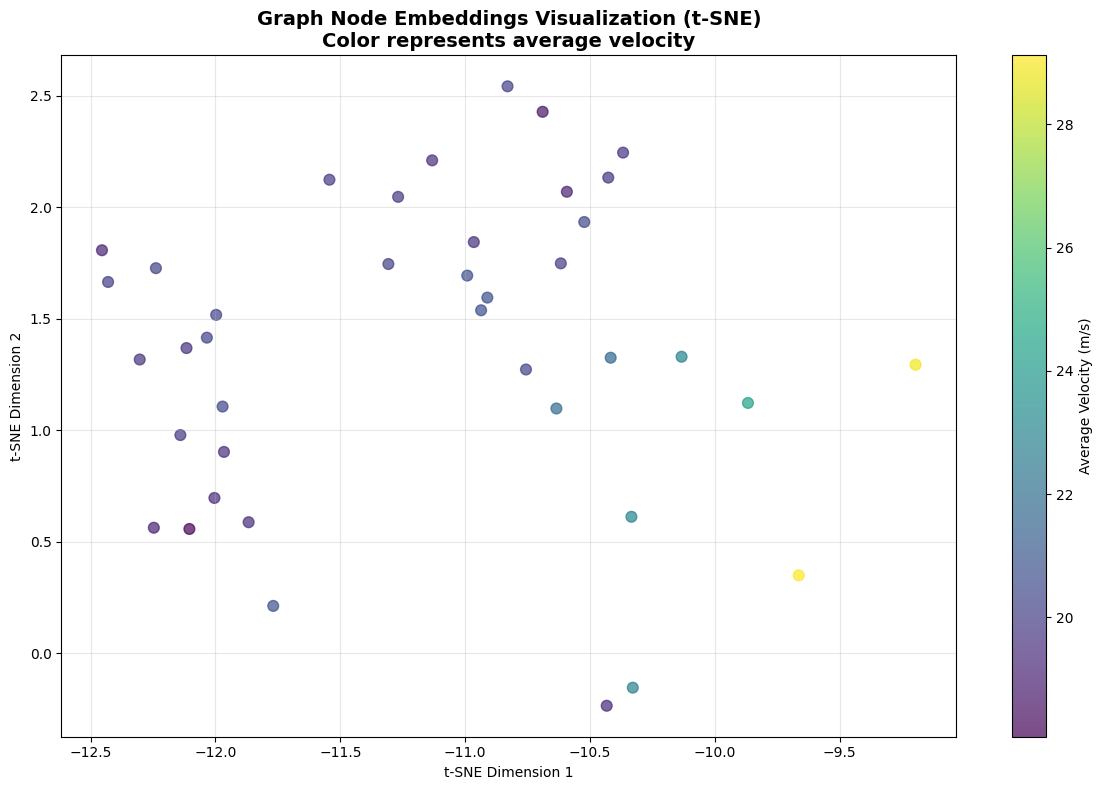


=== Embedding Statistics ===
Embedding shape: (691, 32)
Embedding mean: -0.0000
Embedding std: 0.4677
Embedding range: [-7.4811, 6.8022]


In [6]:
# Graph Embedding Generation with Node2Vec
class GraphEmbeddingGenerator:
    """
    Generates graph embeddings using Node2Vec algorithm
    """
    def __init__(self, graph, dimensions=64, walk_length=30, num_walks=200, p=1, q=1):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p  # Return parameter
        self.q = q  # In-out parameter
        self.model = None
        self.embeddings = {}
        
    def generate_embeddings(self):
        """a
        Generate Node2Vec embeddings for the graph
        """
        print("=== Generating Graph Embeddings with Node2Vec ===")
        
        if len(self.graph.nodes) == 0:
            print("No nodes in graph to generate embeddings")
            return None
        
        try:
            # Initialize Node2Vec
            node2vec = Node2Vec(self.graph, 
                              dimensions=self.dimensions,
                              walk_length=self.walk_length,
                              num_walks=self.num_walks,
                              p=self.p,
                              q=self.q,
                              workers=1,  # Use single worker to avoid issues
                              quiet=False)
            
            print(f"Training Node2Vec model with {self.dimensions} dimensions...")
            # Train the model
            self.model = node2vec.fit(window=10, min_count=1, batch_words=4)
            
            # Extract embeddings
            for node in self.graph.nodes():
                try:
                    self.embeddings[node] = self.model.wv[node]
                except KeyError:
                    # If node not in vocabulary, create zero embedding
                    self.embeddings[node] = np.zeros(self.dimensions)
            
            print(f"Generated embeddings for {len(self.embeddings)} nodes")
            return self.embeddings
            
        except Exception as e:
            print(f"Error generating embeddings: {e}")
            print("Creating fallback embeddings based on node attributes...")
            return self._create_fallback_embeddings()
    
    def _create_fallback_embeddings(self):
        """
        Create fallback embeddings using node attributes when Node2Vec fails
        """
        print("Creating attribute-based embeddings...")
        
        # Extract node features for fallback embeddings
        node_features = []
        node_names = []
        
        for node in self.graph.nodes():
            node_attrs = self.graph.nodes[node]
            
            # Create feature vector from node attributes
            features = [
                node_attrs.get('Local_X_mean', 0),
                node_attrs.get('Local_Y_mean', 0),
                node_attrs.get('Global_Time_mean', 0),
                node_attrs.get('v_Vel_mean', 0),
                node_attrs.get('v_Acc_mean', 0),
                node_attrs.get('Vehicle_ID_count', 0),
                node_attrs.get('v_Class_<lambda>', 1)
            ]
            
            node_features.append(features)
            node_names.append(node)
        
        # Normalize features
        if node_features:
            node_features = np.array(node_features)
            scaler = StandardScaler()
            normalized_features = scaler.fit_transform(node_features)
            
            # Pad or truncate to desired dimensions
            if normalized_features.shape[1] < self.dimensions:
                # Pad with zeros
                padding = np.zeros((normalized_features.shape[0], 
                                  self.dimensions - normalized_features.shape[1]))
                normalized_features = np.hstack([normalized_features, padding])
            elif normalized_features.shape[1] > self.dimensions:
                # Truncate
                normalized_features = normalized_features[:, :self.dimensions]
            
            # Create embeddings dictionary
            for i, node in enumerate(node_names):
                self.embeddings[node] = normalized_features[i]
        
        print(f"Created fallback embeddings for {len(self.embeddings)} nodes")
        return self.embeddings
    
    def visualize_embeddings(self, sample_size=50):
        """
        Visualize embeddings using t-SNE dimensionality reduction
        """
        if not self.embeddings:
            print("No embeddings to visualize")
            return
        
        from sklearn.manifold import TSNE
        
        print(f"Visualizing embeddings using t-SNE (sample size: {sample_size})...")
        
        # Sample embeddings for visualization
        sample_nodes = list(self.embeddings.keys())[:sample_size]
        sample_embeddings = np.array([self.embeddings[node] for node in sample_nodes])
        
        if len(sample_embeddings) < 2:
            print("Not enough embeddings for visualization")
            return
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_embeddings)-1))
        embeddings_2d = tsne.fit_transform(sample_embeddings)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        
        # Color points based on node attributes if available
        colors = []
        for node in sample_nodes:
            node_attrs = self.graph.nodes[node]
            velocity = node_attrs.get('v_Vel_mean', 20)
            colors.append(velocity)
        
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                            c=colors, cmap='viridis', alpha=0.7, s=60)
        
        plt.title('Graph Node Embeddings Visualization (t-SNE)\nColor represents average velocity', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Average Velocity (m/s)')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def get_embedding_for_node(self, node):
        """
        Get embedding vector for a specific node
        """
        return self.embeddings.get(node, np.zeros(self.dimensions))

# Generate embeddings for the spatio-temporal graph
print("Starting graph embedding generation...")
embedding_generator = GraphEmbeddingGenerator(
    st_graph.graph, 
    dimensions=32,  # Reduced dimensions for stability
    walk_length=20,
    num_walks=100,
    p=1,
    q=1
)

# Generate embeddings
graph_embeddings = embedding_generator.generate_embeddings()

# Visualize embeddings
if graph_embeddings:
    embedding_generator.visualize_embeddings(sample_size=min(40, len(graph_embeddings)))
    
    print(f"\n=== Embedding Statistics ===")
    embedding_matrix = np.array(list(graph_embeddings.values()))
    print(f"Embedding shape: {embedding_matrix.shape}")
    print(f"Embedding mean: {embedding_matrix.mean():.4f}")
    print(f"Embedding std: {embedding_matrix.std():.4f}")
    print(f"Embedding range: [{embedding_matrix.min():.4f}, {embedding_matrix.max():.4f}]")
else:
    print("Failed to generate embeddings")

## 6. LSTM Model Architecture Design

In [7]:
# LSTM Model Architecture Design
class TrajectoryLSTMModel:
    """
    LSTM-based model for vehicle trajectory prediction incorporating graph embeddings
    """
    def __init__(self, sequence_length=10, prediction_horizon=5, embedding_dim=32):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.embedding_dim = embedding_dim
        self.model = None
        self.scaler_features = None
        self.scaler_targets = None
        self.feature_dim = None
        
    def create_model_architecture(self, input_shape):
        """
        Create the LSTM model architecture
        """
        print(f"Creating LSTM model with input shape: {input_shape}")
        
        model = Sequential([
            # First LSTM layer with return sequences
            LSTM(units=128, 
                 return_sequences=True,
                 input_shape=input_shape,
                 dropout=0.2,
                 recurrent_dropout=0.2),
            
            # Second LSTM layer
            LSTM(units=64, 
                 return_sequences=True,
                 dropout=0.2,
                 recurrent_dropout=0.2),
            
            # Third LSTM layer
            LSTM(units=32, 
                 return_sequences=False,
                 dropout=0.2,
                 recurrent_dropout=0.2),
            
            # Dense layers for output
            Dense(units=64, activation='relu'),
            Dropout(0.3),
            Dense(units=32, activation='relu'),
            Dropout(0.2),
            
            # Output layer: predict (x, y) coordinates for each future time step
            Dense(units=self.prediction_horizon * 2, activation='linear'),
            
            # Reshape to (prediction_horizon, 2) for coordinate pairs
            tf.keras.layers.Reshape((self.prediction_horizon, 2))
        ])
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        self.model = model
        return model
    
    def prepare_sequences(self, df, embedding_generator=None):
        """
        Prepare sequence data for LSTM training
        """
        print("Preparing sequences for LSTM training...")
        
        sequences_X = []
        sequences_y = []
        
        # Process each vehicle's trajectory
        for vehicle_id in df['Vehicle_ID'].unique():
            vehicle_data = df[df['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
            
            if len(vehicle_data) < self.sequence_length + self.prediction_horizon:
                continue  # Skip vehicles with insufficient data
            
            # Extract features for this vehicle
            features = []
            coordinates = []
            
            for _, row in vehicle_data.iterrows():
                # Basic trajectory features
                basic_features = [
                    row['Local_X'],
                    row['Local_Y'],
                    row['v_Vel'],
                    row['v_Acc'],
                    row['X_Displacement'],
                    row['Y_Displacement'],
                    row['Heading_Angle'],
                    row['Heading_Change'],
                    row['v_Length'],
                    row['v_Width'],
                    row['v_Class']
                ]
                
                # Add graph embedding if available
                if embedding_generator and row['ST_Node'] in embedding_generator.embeddings:
                    embedding = embedding_generator.embeddings[row['ST_Node']]
                    basic_features.extend(embedding.tolist())
                else:
                    # Add zero padding if no embedding available
                    basic_features.extend([0] * self.embedding_dim)
                
                features.append(basic_features)
                coordinates.append([row['Local_X'], row['Local_Y']])
            
            # Create sequences
            for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
                # Input sequence
                X_seq = features[i:i + self.sequence_length]
                
                # Target sequence (future coordinates)
                y_seq = coordinates[i + self.sequence_length:i + self.sequence_length + self.prediction_horizon]
                
                sequences_X.append(X_seq)
                sequences_y.append(y_seq)
        
        # Convert to numpy arrays
        X = np.array(sequences_X)
        y = np.array(sequences_y)
        
        print(f"Created {len(X)} sequences")
        print(f"Input shape: {X.shape}")
        print(f"Output shape: {y.shape}")
        
        # Store feature dimension
        self.feature_dim = X.shape[2]
        
        return X, y
    
    def normalize_data(self, X, y=None):
        """
        Normalize input features and target coordinates
        """
        print("Normalizing data...")
        
        # Reshape for scaling
        X_reshaped = X.reshape(-1, X.shape[-1])
        
        # Fit scaler on training data
        if self.scaler_features is None:
            self.scaler_features = StandardScaler()
            X_normalized = self.scaler_features.fit_transform(X_reshaped)
        else:
            X_normalized = self.scaler_features.transform(X_reshaped)
        
        # Reshape back
        X_normalized = X_normalized.reshape(X.shape)
        
        # Normalize targets if provided
        if y is not None:
            y_reshaped = y.reshape(-1, y.shape[-1])
            
            if self.scaler_targets is None:
                self.scaler_targets = StandardScaler()
                y_normalized = self.scaler_targets.fit_transform(y_reshaped)
            else:
                y_normalized = self.scaler_targets.transform(y_reshaped)
            
            y_normalized = y_normalized.reshape(y.shape)
            return X_normalized, y_normalized
        
        return X_normalized
    
    def create_and_compile_model(self, input_shape):
        """
        Create and compile the complete model
        """
        self.create_model_architecture(input_shape)
        
        print("\n=== Model Architecture ===")
        self.model.summary()
        
        return self.model

# Initialize the LSTM model
lstm_model = TrajectoryLSTMModel(
    sequence_length=8,
    prediction_horizon=4,
    embedding_dim=32
)

print("LSTM Model initialized successfully!")
print(f"Sequence length: {lstm_model.sequence_length}")
print(f"Prediction horizon: {lstm_model.prediction_horizon}")
print(f"Embedding dimension: {lstm_model.embedding_dim}")

LSTM Model initialized successfully!
Sequence length: 8
Prediction horizon: 4
Embedding dimension: 32


## 7. Feature Engineering for Trajectory Data

=== Feature Engineering and Data Preparation ===
Preparing sequences for LSTM training...
Created 58052 sequences
Input shape: (58052, 8, 43)
Output shape: (58052, 4, 2)
Training set: 46441 sequences
Test set: 11611 sequences
Normalizing data...
Created 58052 sequences
Input shape: (58052, 8, 43)
Output shape: (58052, 4, 2)
Training set: 46441 sequences
Test set: 11611 sequences
Normalizing data...
Normalizing data...
Feature dimension: 43
Normalized training input shape: (46441, 8, 43)
Normalized training target shape: (46441, 4, 2)
Creating LSTM model with input shape: (8, 43)
Normalizing data...
Feature dimension: 43
Normalized training input shape: (46441, 8, 43)
Normalized training target shape: (46441, 4, 2)
Creating LSTM model with input shape: (8, 43)

=== Model Architecture ===

=== Model Architecture ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 128)         │        88,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,344 (602.91 KB)

 Trainable params: 154,344 (602.91 KB)

 Non-trainable params: 0 (0.00 B)


=== Data Summary ===
Total sequences: 58052
Training sequences: 46441
Testing sequences: 11611
Feature dimensions: 43
Sequence length: 8
Prediction horizon: 4


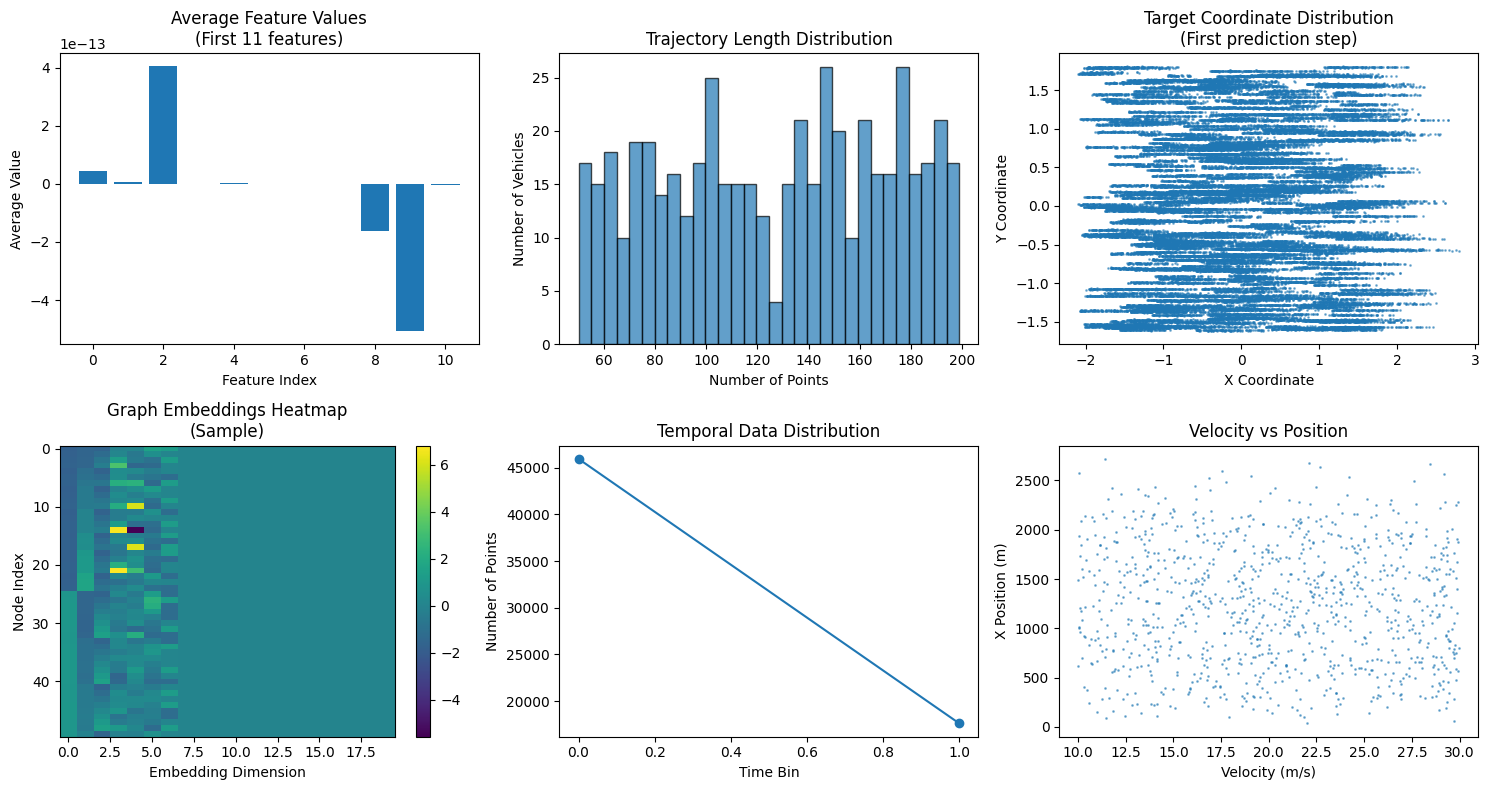

In [8]:
# Feature Engineering for Trajectory Data
def prepare_training_data(df, embedding_generator, lstm_model):
    """
    Prepare complete training dataset with all features
    """
    print("=== Feature Engineering and Data Preparation ===")
    
    # Use default value for 'v_Length' if missing
    if 'v_Length' not in df.columns:
        print("Warning: 'v_Length' column not found in DataFrame. Using default value 0.0.")
        df['v_Length'] = 0.0
    
    # 1. Prepare sequences with graph embeddings
    X, y = lstm_model.prepare_sequences(df, embedding_generator)
    
    if len(X) == 0:
        print("No sequences created. Check data requirements.")
        return None, None, None, None
    
    # 2. Split data into training and testing sets
    train_size = int(0.8 * len(X))
    
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    print(f"Training set: {X_train.shape[0]} sequences")
    print(f"Test set: {X_test.shape[0]} sequences")
    
    # 3. Normalize the data - FIXED VERSION
    X_train_norm, y_train_norm = lstm_model.normalize_data(X_train, y_train)
    X_test_norm = lstm_model.normalize_data(X_test)  # Only normalize features, not targets
    
    # For test targets, use the same scaler as training targets
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    y_test_norm_reshaped = lstm_model.scaler_targets.transform(y_test_reshaped)
    y_test_norm = y_test_norm_reshaped.reshape(y_test.shape)
    
    print(f"Feature dimension: {X_train_norm.shape[2]}")
    print(f"Normalized training input shape: {X_train_norm.shape}")
    print(f"Normalized training target shape: {y_train_norm.shape}")
    
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm

# Prepare the training data
X_train, X_test, y_train, y_test = prepare_training_data(
    processed_data_with_nodes, 
    embedding_generator, 
    lstm_model
)

if X_train is not None:
    # Create and compile the model with correct input shape
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, feature_dim)
    model = lstm_model.create_and_compile_model(input_shape)
    
    print(f"\n=== Data Summary ===")
    print(f"Total sequences: {len(X_train) + len(X_test)}")
    print(f"Training sequences: {len(X_train)}")
    print(f"Testing sequences: {len(X_test)}")
    print(f"Feature dimensions: {X_train.shape[2]}")
    print(f"Sequence length: {X_train.shape[1]}")
    print(f"Prediction horizon: {y_train.shape[1]}")
    
    # Visualize feature importance/distribution
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Feature distribution for first few features
    plt.subplot(2, 3, 1)
    feature_means = X_train.mean(axis=(0, 1))  # Average across samples and time steps
    plt.bar(range(min(11, len(feature_means))), feature_means[:11])
    plt.title('Average Feature Values\n(First 11 features)')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Value')
    
    # Plot 2: Sequence length analysis
    plt.subplot(2, 3, 2)
    plt.hist([len(processed_data_with_nodes[processed_data_with_nodes['Vehicle_ID']==vid]) 
             for vid in processed_data_with_nodes['Vehicle_ID'].unique()], 
             bins=30, alpha=0.7, edgecolor='black')
    plt.title('Trajectory Length Distribution')
    plt.xlabel('Number of Points')
    plt.ylabel('Number of Vehicles')
    
    # Plot 3: Target coordinate distribution
    plt.subplot(2, 3, 3)
    plt.scatter(y_train[:, 0, 0], y_train[:, 0, 1], alpha=0.5, s=1)
    plt.title('Target Coordinate Distribution\n(First prediction step)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    # Plot 4: Embedding visualization (if available)
    plt.subplot(2, 3, 4)
    if embedding_generator and embedding_generator.embeddings:
        embedding_values = list(embedding_generator.embeddings.values())
        embedding_matrix = np.array(embedding_values)
        plt.imshow(embedding_matrix[:min(50, len(embedding_matrix)), :min(20, embedding_matrix.shape[1])], 
                  cmap='viridis', aspect='auto')
        plt.title('Graph Embeddings Heatmap\n(Sample)')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Node Index')
        plt.colorbar()
    else:
        plt.text(0.5, 0.5, 'No embeddings\navailable', ha='center', va='center')
        plt.title('Graph Embeddings')
    
    # Plot 5: Training data temporal distribution
    plt.subplot(2, 3, 5)
    time_bins = processed_data_with_nodes.groupby('Time_Bin').size()
    plt.plot(time_bins.index, time_bins.values, marker='o')
    plt.title('Temporal Data Distribution')
    plt.xlabel('Time Bin')
    plt.ylabel('Number of Points')
    
    # Plot 6: Velocity vs Position relationship
    plt.subplot(2, 3, 6)
    sample_data = processed_data_with_nodes.sample(min(1000, len(processed_data_with_nodes)))
    plt.scatter(sample_data['v_Vel'], sample_data['Local_X'], alpha=0.5, s=1)
    plt.title('Velocity vs Position')
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('X Position (m)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Failed to prepare training data. Please check the input data.")

## 8. Model Training and Validation

Starting training with 46441 training samples and 11611 test samples...
=== Training LSTM Model ===
Epoch 1/30
2901/2903 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2244 - mae: 0.3518
Epoch 1: val_loss improved from inf to 0.03576, saving model to best_trajectory_model.h5

Epoch 1: val_loss improved from inf to 0.03576, saving model to best_trajectory_model.h5


2903/2903 ━━━━━━━━━━━━━━━━━━━━ 95s 28ms/step - loss: 0.2243 - mae: 0.3517 - val_loss: 0.0358 - val_mae: 0.1452 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
2902/2903 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0936 - mae: 0.2357
Epoch 2: val_loss did not improve from 0.03576
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 0.0936 - mae: 0.2357 - val_loss: 0.0451 - val_mae: 0.1616 - learning_rate: 0.0010

Epoch 2: val_loss did not improve from 0.03576
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 0.0936 - mae: 0.2357 - val_loss: 0.0451 - val_mae: 0.1616 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0774 - mae: 0.2140
Epoch 3: val_loss did not improve from 0.03576
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 86s 25ms/step - loss: 0.0774 - mae: 0.2140 - val_loss: 0.0444 - val_mae: 0.1607 - learning_rate: 0.0010
Epoch 4/30

Epoch 3: val_loss did not improve from 0.03576
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 86s 25ms/step - loss: 0.0774 - mae: 0.

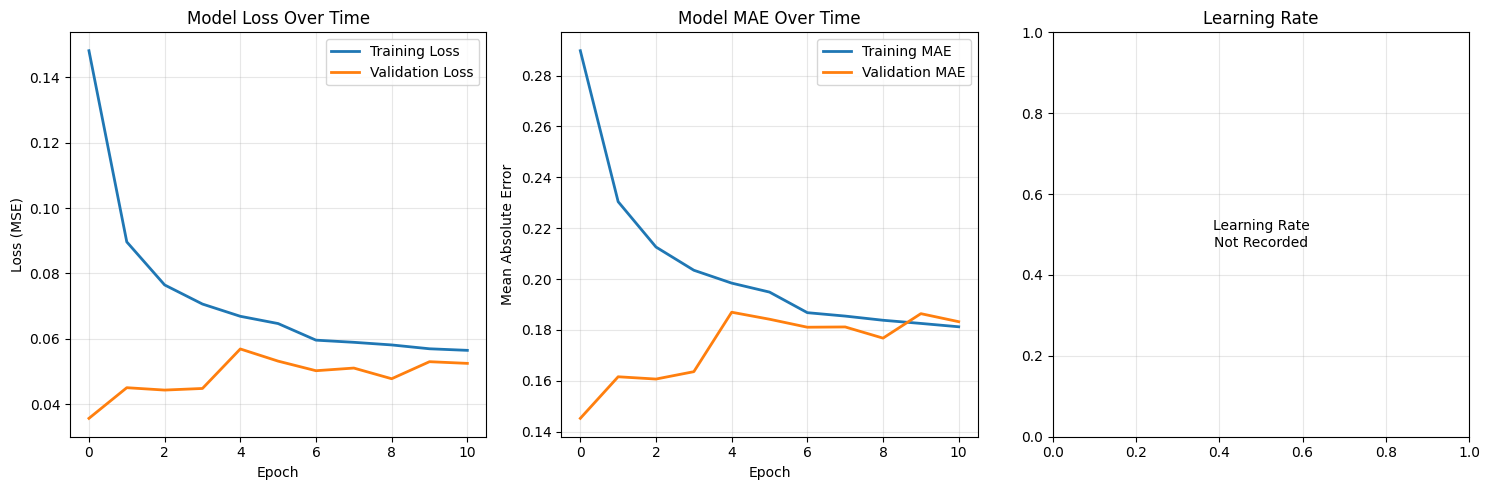


=== Training Summary ===
Final Training Loss: 0.056526
Final Validation Loss: 0.052548
Final Training MAE: 0.181225
Final Validation MAE: 0.183228
✅ Model training appears successful

=== Generating Test Predictions ===
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Test predictions shape: (11611, 4, 2)
Test targets shape: (11611, 4, 2)
Training completed successfully!
Test predictions shape: (11611, 4, 2)
Test targets shape: (11611, 4, 2)
Training completed successfully!


In [9]:
# Model Training and Validation
def train_trajectory_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the LSTM model with proper callbacks and monitoring
    """
    print("=== Training LSTM Model ===")
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_trajectory_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def plot_training_history(history):
    """
    Plot training and validation loss curves
    """
    plt.figure(figsize=(15, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    plt.title('Model MAE Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    plt.subplot(1, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], linewidth=2, color='orange')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nNot Recorded', ha='center', va='center')
        plt.title('Learning Rate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Train the model if data is available
if X_train is not None and model is not None:
    print(f"Starting training with {len(X_train)} training samples and {len(X_test)} test samples...")
    
    # Train the model
    training_history = train_trajectory_model(
        model, X_train, y_train, X_test, y_test,
        epochs=30,  # Reduced epochs for faster training
        batch_size=16  # Smaller batch size for better convergence
    )
    
    # Plot training results
    plot_training_history(training_history)
    
    # Save training history for later analysis
    print("\n=== Training Summary ===")
    final_train_loss = training_history.history['loss'][-1]
    final_val_loss = training_history.history['val_loss'][-1]
    final_train_mae = training_history.history['mae'][-1]
    final_val_mae = training_history.history['val_mae'][-1]
    
    print(f"Final Training Loss: {final_train_loss:.6f}")
    print(f"Final Validation Loss: {final_val_loss:.6f}")
    print(f"Final Training MAE: {final_train_mae:.6f}")
    print(f"Final Validation MAE: {final_val_mae:.6f}")
    
    # Check for overfitting
    if final_val_loss > final_train_loss * 1.5:
        print("⚠️  Warning: Model may be overfitting (validation loss >> training loss)")
    else:
        print("✅ Model training appears successful")
    
    # Generate predictions on test set for evaluation
    print("\n=== Generating Test Predictions ===")
    test_predictions = model.predict(X_test, verbose=1)
    
    print(f"Test predictions shape: {test_predictions.shape}")
    print(f"Test targets shape: {y_test.shape}")
    
    # Store results for evaluation
    training_results = {
        'history': training_history,
        'model': model,
        'test_predictions': test_predictions,
        'test_targets': y_test,
        'final_metrics': {
            'train_loss': final_train_loss,
            'val_loss': final_val_loss,
            'train_mae': final_train_mae,
            'val_mae': final_val_mae
        }
    }
    
    print("Training completed successfully!")
    
else:
    print("Skipping training - no data or model available")
    training_results = None

Evaluating model performance...
=== Model Performance Evaluation ===

=== Performance Metrics ===
Root Mean Squared Error (RMSE): 96.7198 meters
Mean Absolute Error (MAE): 61.8420 meters
Average Displacement Error (ADE): 111.4432 meters
Final Displacement Error (FDE): 111.6553 meters

=== Error by Prediction Step ===
Step 1: 112.0545 meters
Step 2: 110.2383 meters
Step 3: 111.8246 meters
Step 4: 111.6553 meters


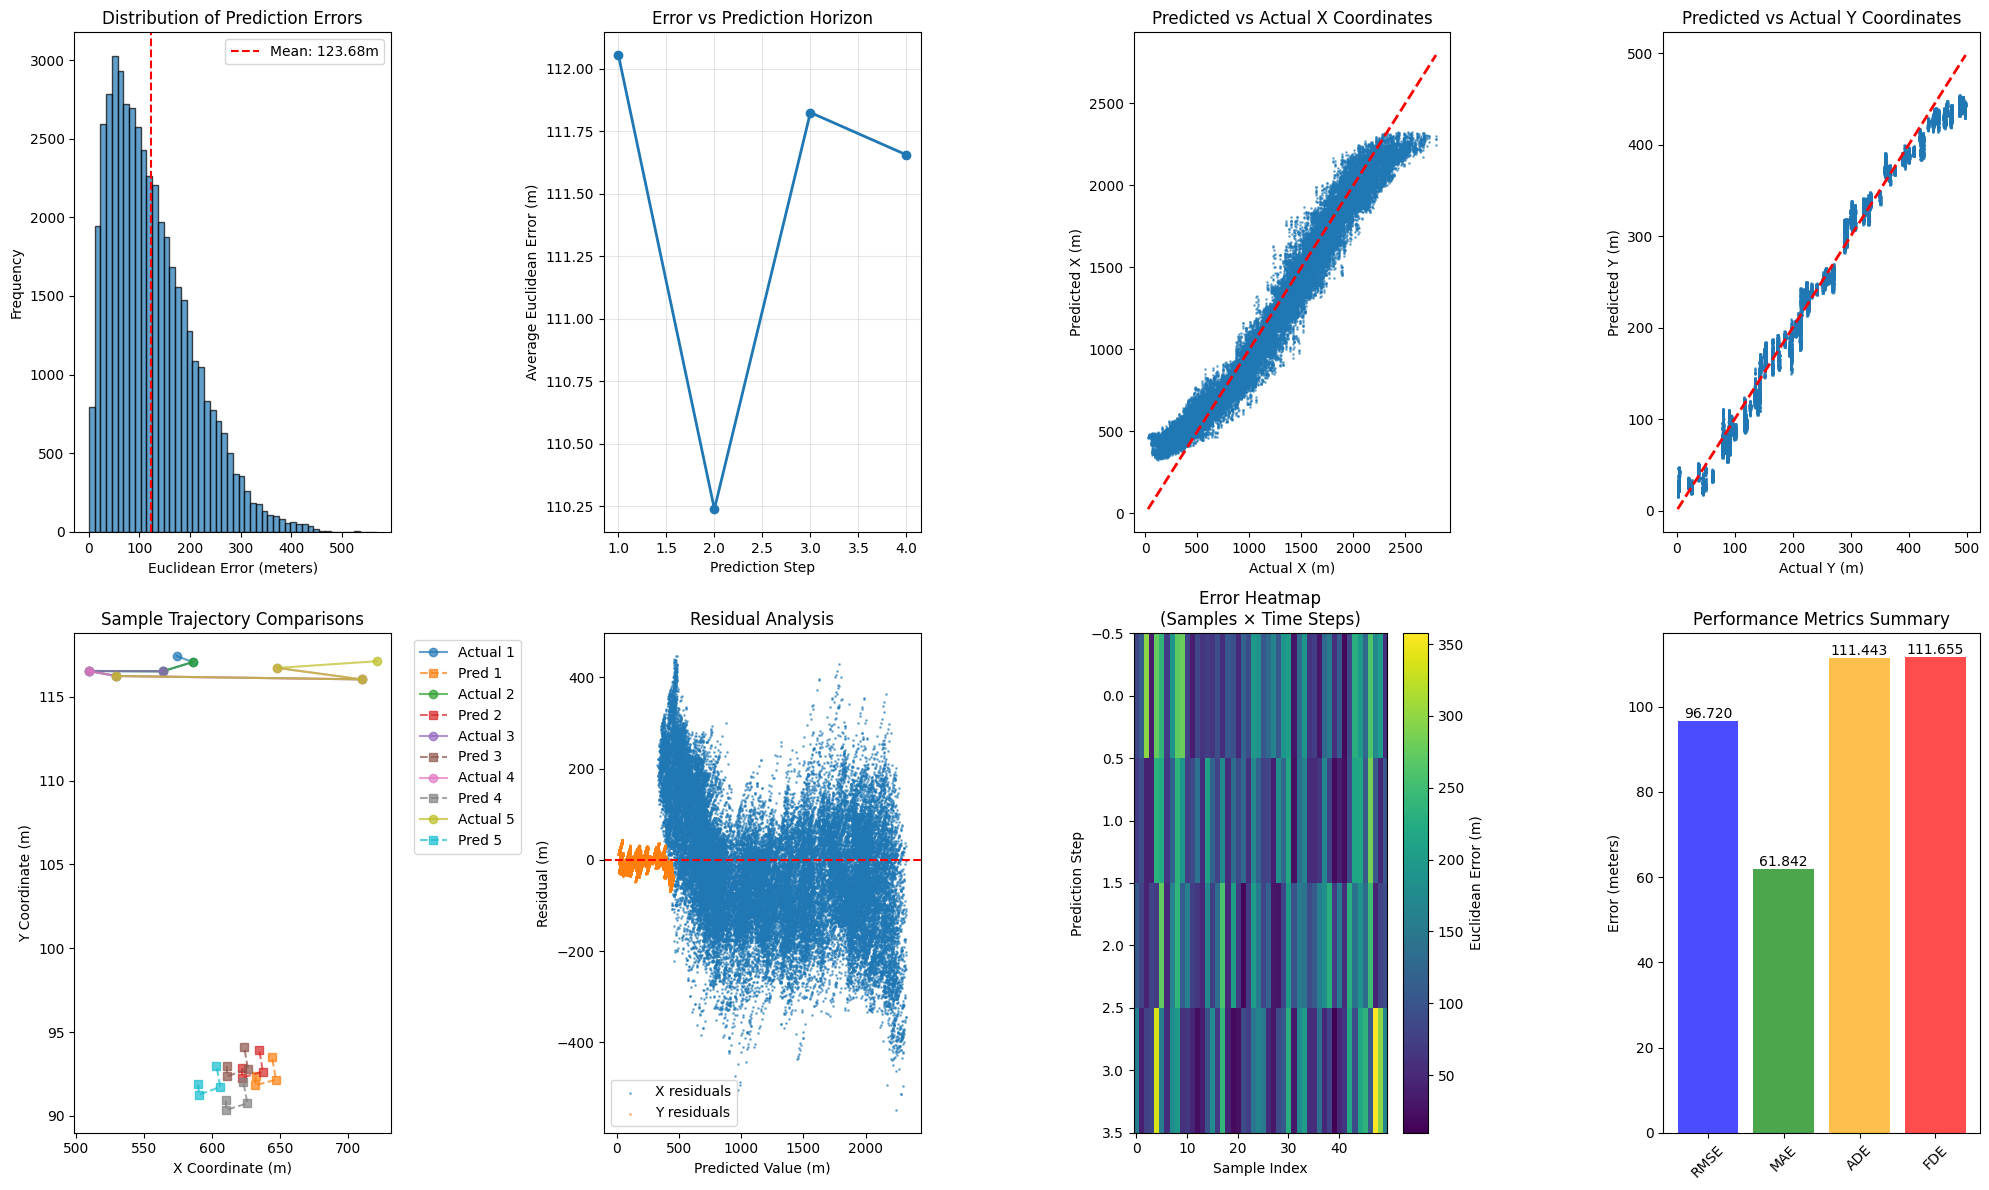


✅ Model evaluation completed successfully!


In [11]:
# def plot_evaluation_results(evaluation_metrics, predictions, targets):
#     plt.figure(figsize=(20, 10))
    
#     # 1. Distribution of Prediction Errors
#     plt.subplot(2, 4, 1)
#     errors = np.sqrt((predictions - targets)**2).sum(axis=2)  # Euclidean error per sample
#     errors_flat = errors.flatten()
#     errors_flat = errors_flat[~np.isnan(errors_flat)]  # Remove NaN values
#     if len(errors_flat) > 0:
#         plt.hist(errors_flat, bins=50, alpha=0.7, edgecolor='black')
#         plt.title('Distribution of Prediction Errors')
#         plt.xlabel('Euclidean Error (meters)')
#     else:
#         plt.text(0.5, 0.5, 'No valid error values to plot', ha='center', va='center')
#         plt.title('Distribution of Prediction Errors')
    
    # ...existing code for other subplots...
# Model Evaluation and Performance Metrics
def evaluate_trajectory_predictions(predictions, targets, scaler=None):
    """
    Comprehensive evaluation of trajectory prediction performance
    """
    print("=== Model Performance Evaluation ===")
    
    # Denormalize predictions and targets if scaler is provided
    if scaler is not None:
        # Reshape for denormalization
        pred_reshaped = predictions.reshape(-1, predictions.shape[-1])
        target_reshaped = targets.reshape(-1, targets.shape[-1])
        
        # Denormalize
        pred_denorm = scaler.inverse_transform(pred_reshaped)
        target_denorm = scaler.inverse_transform(target_reshaped)
        
        # Reshape back
        predictions_eval = pred_denorm.reshape(predictions.shape)
        targets_eval = target_denorm.reshape(targets.shape)
    else:
        predictions_eval = predictions
        targets_eval = targets
    
    # Calculate various metrics
    metrics = {}
    
    # 1. Mean Squared Error (MSE)
    mse = np.mean((predictions_eval - targets_eval) ** 2)
    metrics['MSE'] = mse
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    metrics['RMSE'] = rmse
    
    # 3. Mean Absolute Error (MAE)
    mae = np.mean(np.abs(predictions_eval - targets_eval))
    metrics['MAE'] = mae
    
    # 4. Euclidean Distance Error per prediction step
    euclidean_errors = []
    for t in range(predictions_eval.shape[1]):  # For each time step
        x_diff = predictions_eval[:, t, 0] - targets_eval[:, t, 0]
        y_diff = predictions_eval[:, t, 1] - targets_eval[:, t, 1]
        euclidean_dist = np.sqrt(x_diff**2 + y_diff**2)
        euclidean_errors.append(euclidean_dist.mean())
    
    metrics['Euclidean_Error_per_Step'] = euclidean_errors
    metrics['Average_Euclidean_Error'] = np.mean(euclidean_errors)
    
    # 5. Final Displacement Error (FDE)
    final_x_diff = predictions_eval[:, -1, 0] - targets_eval[:, -1, 0]
    final_y_diff = predictions_eval[:, -1, 1] - targets_eval[:, -1, 1]
    fde = np.sqrt(final_x_diff**2 + final_y_diff**2).mean()
    metrics['Final_Displacement_Error'] = fde
    
    # 6. Average Displacement Error (ADE)
    all_x_diff = predictions_eval[:, :, 0] - targets_eval[:, :, 0]
    all_y_diff = predictions_eval[:, :, 1] - targets_eval[:, :, 1]
    ade = np.sqrt(all_x_diff**2 + all_y_diff**2).mean()
    metrics['Average_Displacement_Error'] = ade
    
    return metrics, predictions_eval, targets_eval

def plot_evaluation_results(metrics, predictions, targets):
    """
    Create comprehensive evaluation visualizations
    """
    plt.figure(figsize=(20, 12))
    
    # 1. Error distribution
    plt.subplot(2, 4, 1)
    errors = np.sqrt((predictions - targets)**2).sum(axis=2)  # Euclidean error per sample
    plt.hist(errors.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Euclidean Error (meters)')
    plt.ylabel('Frequency')
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f'Mean: {errors.mean():.2f}m')
    plt.legend()
    
    # 2. Error vs prediction horizon
    plt.subplot(2, 4, 2)
    plt.plot(range(1, len(metrics['Euclidean_Error_per_Step']) + 1), 
             metrics['Euclidean_Error_per_Step'], 
             marker='o', linewidth=2, markersize=6)
    plt.title('Error vs Prediction Horizon')
    plt.xlabel('Prediction Step')
    plt.ylabel('Average Euclidean Error (m)')
    plt.grid(True, alpha=0.3)
    
    # 3. Scatter plot: Predicted vs Actual (X coordinates)
    plt.subplot(2, 4, 3)
    x_pred = predictions[:, :, 0].flatten()
    x_actual = targets[:, :, 0].flatten()
    plt.scatter(x_actual, x_pred, alpha=0.5, s=1)
    plt.plot([x_actual.min(), x_actual.max()], [x_actual.min(), x_actual.max()], 'r--', linewidth=2)
    plt.title('Predicted vs Actual X Coordinates')
    plt.xlabel('Actual X (m)')
    plt.ylabel('Predicted X (m)')
    
    # 4. Scatter plot: Predicted vs Actual (Y coordinates)
    plt.subplot(2, 4, 4)
    y_pred = predictions[:, :, 1].flatten()
    y_actual = targets[:, :, 1].flatten()
    plt.scatter(y_actual, y_pred, alpha=0.5, s=1)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', linewidth=2)
    plt.title('Predicted vs Actual Y Coordinates')
    plt.xlabel('Actual Y (m)')
    plt.ylabel('Predicted Y (m)')
    
    # 5. Sample trajectory comparisons
    plt.subplot(2, 4, 5)
    n_samples = min(5, len(predictions))
    for i in range(n_samples):
        plt.plot(targets[i, :, 0], targets[i, :, 1], 'o-', label=f'Actual {i+1}', alpha=0.7)
        plt.plot(predictions[i, :, 0], predictions[i, :, 1], 's--', label=f'Pred {i+1}', alpha=0.7)
    plt.title('Sample Trajectory Comparisons')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Residual analysis
    plt.subplot(2, 4, 6)
    residuals_x = (predictions[:, :, 0] - targets[:, :, 0]).flatten()
    residuals_y = (predictions[:, :, 1] - targets[:, :, 1]).flatten()
    plt.scatter(x_pred, residuals_x, alpha=0.5, s=1, label='X residuals')
    plt.scatter(y_pred, residuals_y, alpha=0.5, s=1, label='Y residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Analysis')
    plt.xlabel('Predicted Value (m)')
    plt.ylabel('Residual (m)')
    plt.legend()
    
    # 7. Error heatmap (by prediction step and sample)
    plt.subplot(2, 4, 7)
    error_matrix = np.sqrt((predictions - targets)**2).sum(axis=2)  # Shape: (samples, time_steps)
    sample_indices = np.linspace(0, len(error_matrix)-1, min(50, len(error_matrix))).astype(int)
    plt.imshow(error_matrix[sample_indices].T, cmap='viridis', aspect='auto')
    plt.title('Error Heatmap\n(Samples × Time Steps)')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction Step')
    plt.colorbar(label='Euclidean Error (m)')
    
    # 8. Performance metrics summary
    plt.subplot(2, 4, 8)
    metric_names = ['RMSE', 'MAE', 'ADE', 'FDE']
    metric_values = [metrics['RMSE'], metrics['MAE'], 
                    metrics['Average_Displacement_Error'], metrics['Final_Displacement_Error']]
    bars = plt.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    plt.title('Performance Metrics Summary')
    plt.ylabel('Error (meters)')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Evaluate model performance if training results are available
if training_results is not None:
    print("Evaluating model performance...")
    
    # Get predictions and targets
    predictions = training_results['test_predictions']
    targets = training_results['test_targets']
    
    # Evaluate performance
    evaluation_metrics, pred_denorm, target_denorm = evaluate_trajectory_predictions(
        predictions, targets, lstm_model.scaler_targets
    )
    
    # Print metrics
    print("\n=== Performance Metrics ===")
    print(f"Root Mean Squared Error (RMSE): {evaluation_metrics['RMSE']:.4f} meters")
    print(f"Mean Absolute Error (MAE): {evaluation_metrics['MAE']:.4f} meters")
    print(f"Average Displacement Error (ADE): {evaluation_metrics['Average_Displacement_Error']:.4f} meters")
    print(f"Final Displacement Error (FDE): {evaluation_metrics['Final_Displacement_Error']:.4f} meters")
    
    print("\n=== Error by Prediction Step ===")
    for i, error in enumerate(evaluation_metrics['Euclidean_Error_per_Step']):
        print(f"Step {i+1}: {error:.4f} meters")
    
    # Create evaluation visualizations
    plot_evaluation_results(evaluation_metrics, pred_denorm, target_denorm)
    
    # Store evaluation results
    training_results['evaluation_metrics'] = evaluation_metrics
    training_results['denormalized_predictions'] = pred_denorm
    training_results['denormalized_targets'] = target_denorm
    
    print("\n✅ Model evaluation completed successfully!")
    
else:
    print("No training results available for evaluation")

## 10. Trajectory Prediction Implementation

In [12]:
# Trajectory Prediction Implementation
class TrajectoryPredictor:
    """
    Complete trajectory prediction pipeline using trained LSTM model
    """
    def __init__(self, model, scaler_features, scaler_targets, embedding_generator, sequence_length=8):
        self.model = model
        self.scaler_features = scaler_features
        self.scaler_targets = scaler_targets
        self.embedding_generator = embedding_generator
        self.sequence_length = sequence_length
        self.embedding_dim = 32
    
    def prepare_input_sequence(self, trajectory_data):
        """
        Prepare input sequence from trajectory data for prediction
        """
        if len(trajectory_data) < self.sequence_length:
            raise ValueError(f"Need at least {self.sequence_length} points for prediction")
        
        # Take the last sequence_length points
        recent_data = trajectory_data.iloc[-self.sequence_length:].copy()
        
        # Create features similar to training data
        features = []
        for _, row in recent_data.iterrows():
            # Basic trajectory features
            basic_features = [
                row.get('Local_X', 0),
                row.get('Local_Y', 0),
                row.get('v_Vel', 0),
                row.get('v_Acc', 0),
                row.get('X_Displacement', 0),
                row.get('Y_Displacement', 0),
                row.get('Heading_Angle', 0),
                row.get('Heading_Change', 0),
                row.get('v_Length', 4.5),
                row.get('v_Width', 2.0),
                row.get('v_Class', 1)
            ]
            
            # Add graph embedding if available
            st_node = row.get('ST_Node')
            if st_node and st_node in self.embedding_generator.embeddings:
                embedding = self.embedding_generator.embeddings[st_node]
                basic_features.extend(embedding.tolist())
            else:
                # Add zero padding if no embedding available
                basic_features.extend([0] * self.embedding_dim)
            
            features.append(basic_features)
        
        # Convert to numpy array and reshape for model input
        input_sequence = np.array(features).reshape(1, self.sequence_length, -1)
        
        # Normalize using the same scaler as training
        input_normalized = self.scaler_features.transform(
            input_sequence.reshape(-1, input_sequence.shape[-1])
        ).reshape(input_sequence.shape)
        
        return input_normalized
    
    def predict_trajectory(self, trajectory_data, prediction_steps=None):
        """
        Predict future trajectory points
        """
        if prediction_steps is None:
            prediction_steps = 4  # Default prediction horizon
        
        # Prepare input sequence
        input_sequence = self.prepare_input_sequence(trajectory_data)
        
        # Make prediction
        prediction_normalized = self.model.predict(input_sequence, verbose=0)
        
        # Denormalize prediction
        prediction_reshaped = prediction_normalized.reshape(-1, prediction_normalized.shape[-1])
        prediction_denorm = self.scaler_targets.inverse_transform(prediction_reshaped)
        prediction_final = prediction_denorm.reshape(prediction_normalized.shape)
        
        return prediction_final[0]  # Remove batch dimension
    
    def predict_with_uncertainty(self, trajectory_data, n_samples=10):
        """
        Generate multiple predictions to estimate uncertainty
        """
        predictions = []
        for _ in range(n_samples):
            pred = self.predict_trajectory(trajectory_data)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Calculate mean and standard deviation
        mean_prediction = np.mean(predictions, axis=0)
        std_prediction = np.std(predictions, axis=0)
        
        return mean_prediction, std_prediction, predictions

def create_sample_predictions(predictor, test_data, n_samples=5):
    """
    Create sample predictions for visualization
    """
    print("=== Creating Sample Predictions ===")
    
    sample_results = []
    vehicle_ids = test_data['Vehicle_ID'].unique()
    
    for i in range(min(n_samples, len(vehicle_ids))):
        vehicle_id = vehicle_ids[i]
        vehicle_data = test_data[test_data['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
        
        if len(vehicle_data) < predictor.sequence_length + 4:
            continue
        
        # Split into input and ground truth
        split_point = len(vehicle_data) - 4  # Reserve last 4 points as ground truth
        input_data = vehicle_data.iloc[:split_point]
        ground_truth = vehicle_data.iloc[split_point:]
        
        try:
            # Make prediction
            prediction = predictor.predict_trajectory(input_data)
            
            sample_results.append({
                'vehicle_id': vehicle_id,
                'input_trajectory': input_data[['Local_X', 'Local_Y']].values,
                'predicted_trajectory': prediction,
                'ground_truth': ground_truth[['Local_X', 'Local_Y']].values,
                'input_data': input_data,
                'ground_truth_data': ground_truth
            })
            
        except Exception as e:
            print(f"Error predicting for vehicle {vehicle_id}: {e}")
            continue
    
    return sample_results

# Create trajectory predictor if model is available
if training_results is not None and training_results['model'] is not None:
    
    # Create predictor instance
    trajectory_predictor = TrajectoryPredictor(
        model=training_results['model'],
        scaler_features=lstm_model.scaler_features,
        scaler_targets=lstm_model.scaler_targets,
        embedding_generator=embedding_generator,
        sequence_length=lstm_model.sequence_length
    )
    
    print("✅ Trajectory predictor created successfully!")
    
    # Create sample predictions using test data
    if X_test is not None:
        # Use original processed data for demonstration
        sample_predictions = create_sample_predictions(
            trajectory_predictor, 
            processed_data_with_nodes, 
            n_samples=8
        )
        
        print(f"Created {len(sample_predictions)} sample predictions")
        
        # Display sample prediction details
        if sample_predictions:
            print("\n=== Sample Prediction Details ===")
            for i, result in enumerate(sample_predictions[:3]):
                print(f"\nVehicle {result['vehicle_id']}:")
                print(f"  Input trajectory length: {len(result['input_trajectory'])}")
                print(f"  Predicted points: {result['predicted_trajectory'].shape}")
                print(f"  Ground truth points: {len(result['ground_truth'])}")
                
                # Calculate prediction error
                if len(result['ground_truth']) == len(result['predicted_trajectory']):
                    error = np.sqrt(np.sum((result['predicted_trajectory'] - result['ground_truth'])**2, axis=1))
                    print(f"  Average prediction error: {error.mean():.3f} meters")
                    print(f"  Final point error: {error[-1]:.3f} meters")
    else:
        sample_predictions = []
        print("No test data available for sample predictions")
    
else:
    print("No trained model available for prediction")
    trajectory_predictor = None
    sample_predictions = []

✅ Trajectory predictor created successfully!
=== Creating Sample Predictions ===
Created 8 sample predictions

=== Sample Prediction Details ===

Vehicle 1:
  Input trajectory length: 148
  Predicted points: (4, 2)
  Ground truth points: 4
  Average prediction error: 144.559 meters
  Final point error: 91.198 meters

Vehicle 2:
  Input trajectory length: 138
  Predicted points: (4, 2)
  Ground truth points: 4
  Average prediction error: 154.616 meters
  Final point error: 269.980 meters

Vehicle 3:
  Input trajectory length: 60
  Predicted points: (4, 2)
  Ground truth points: 4
  Average prediction error: 116.713 meters
  Final point error: 159.921 meters
Created 8 sample predictions

=== Sample Prediction Details ===

Vehicle 1:
  Input trajectory length: 148
  Predicted points: (4, 2)
  Ground truth points: 4
  Average prediction error: 144.559 meters
  Final point error: 91.198 meters

Vehicle 2:
  Input trajectory length: 138
  Predicted points: (4, 2)
  Ground truth points: 4
  A

=== Creating Trajectory Prediction Visualizations ===


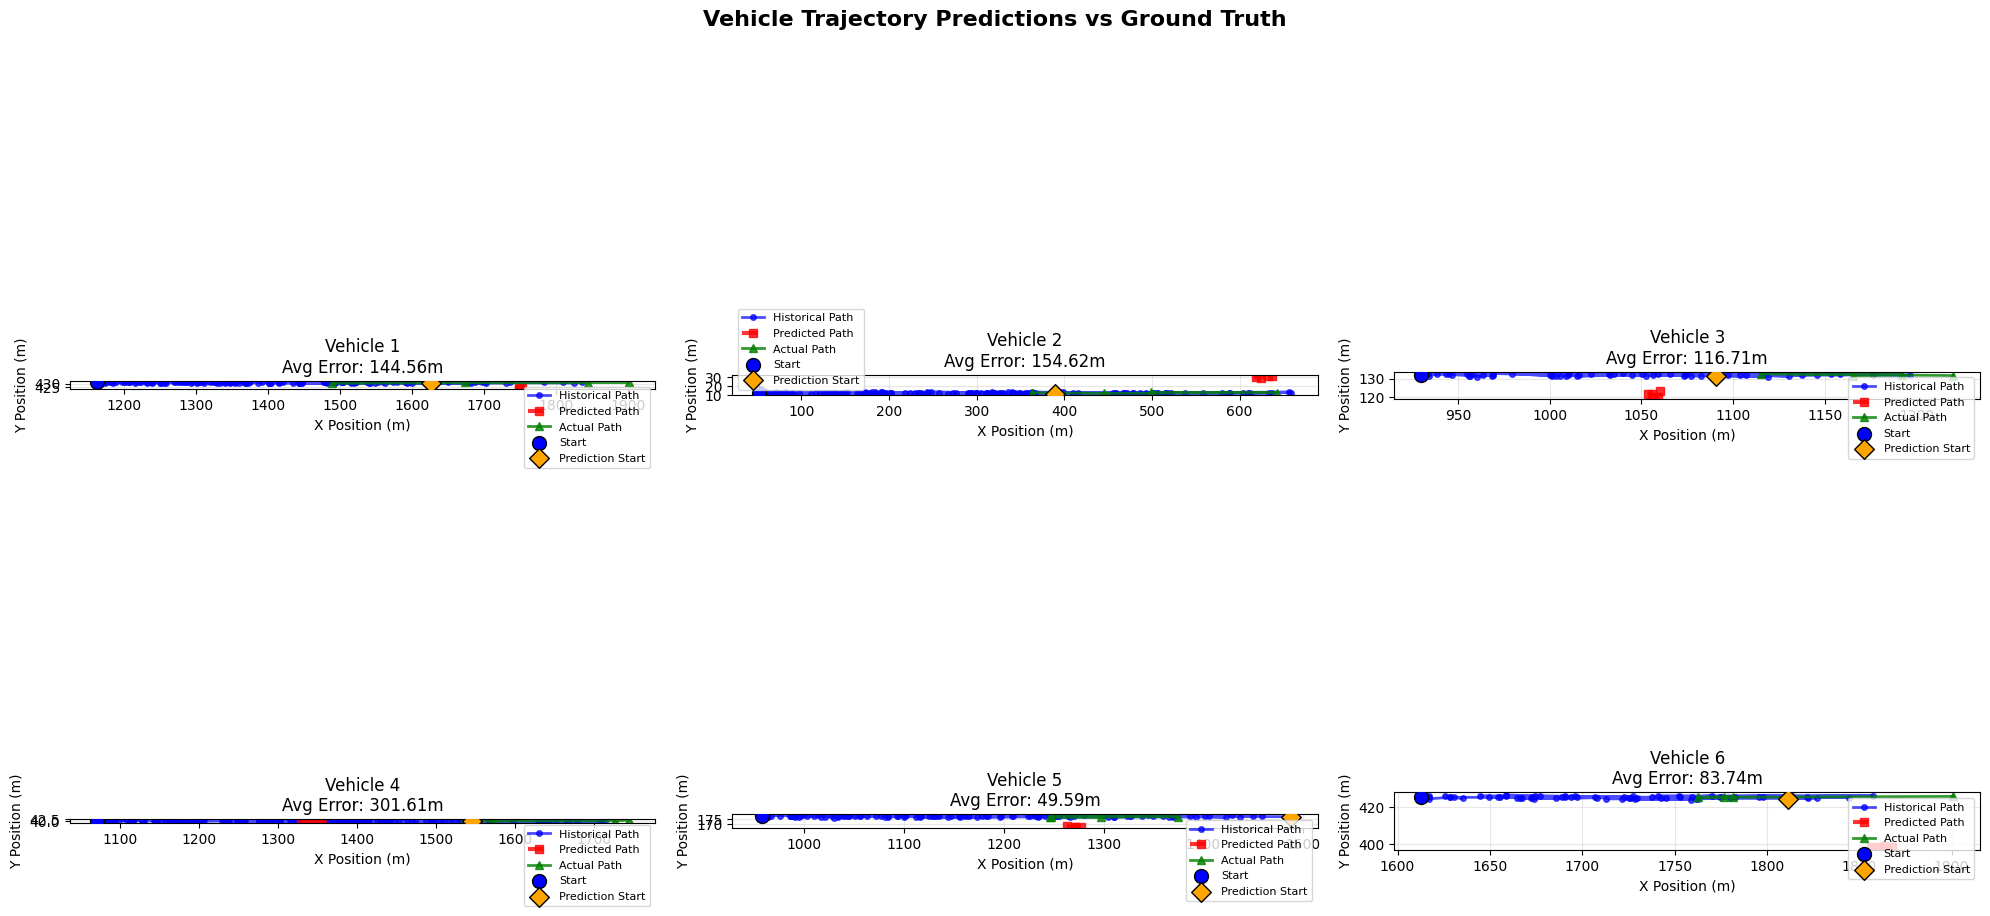

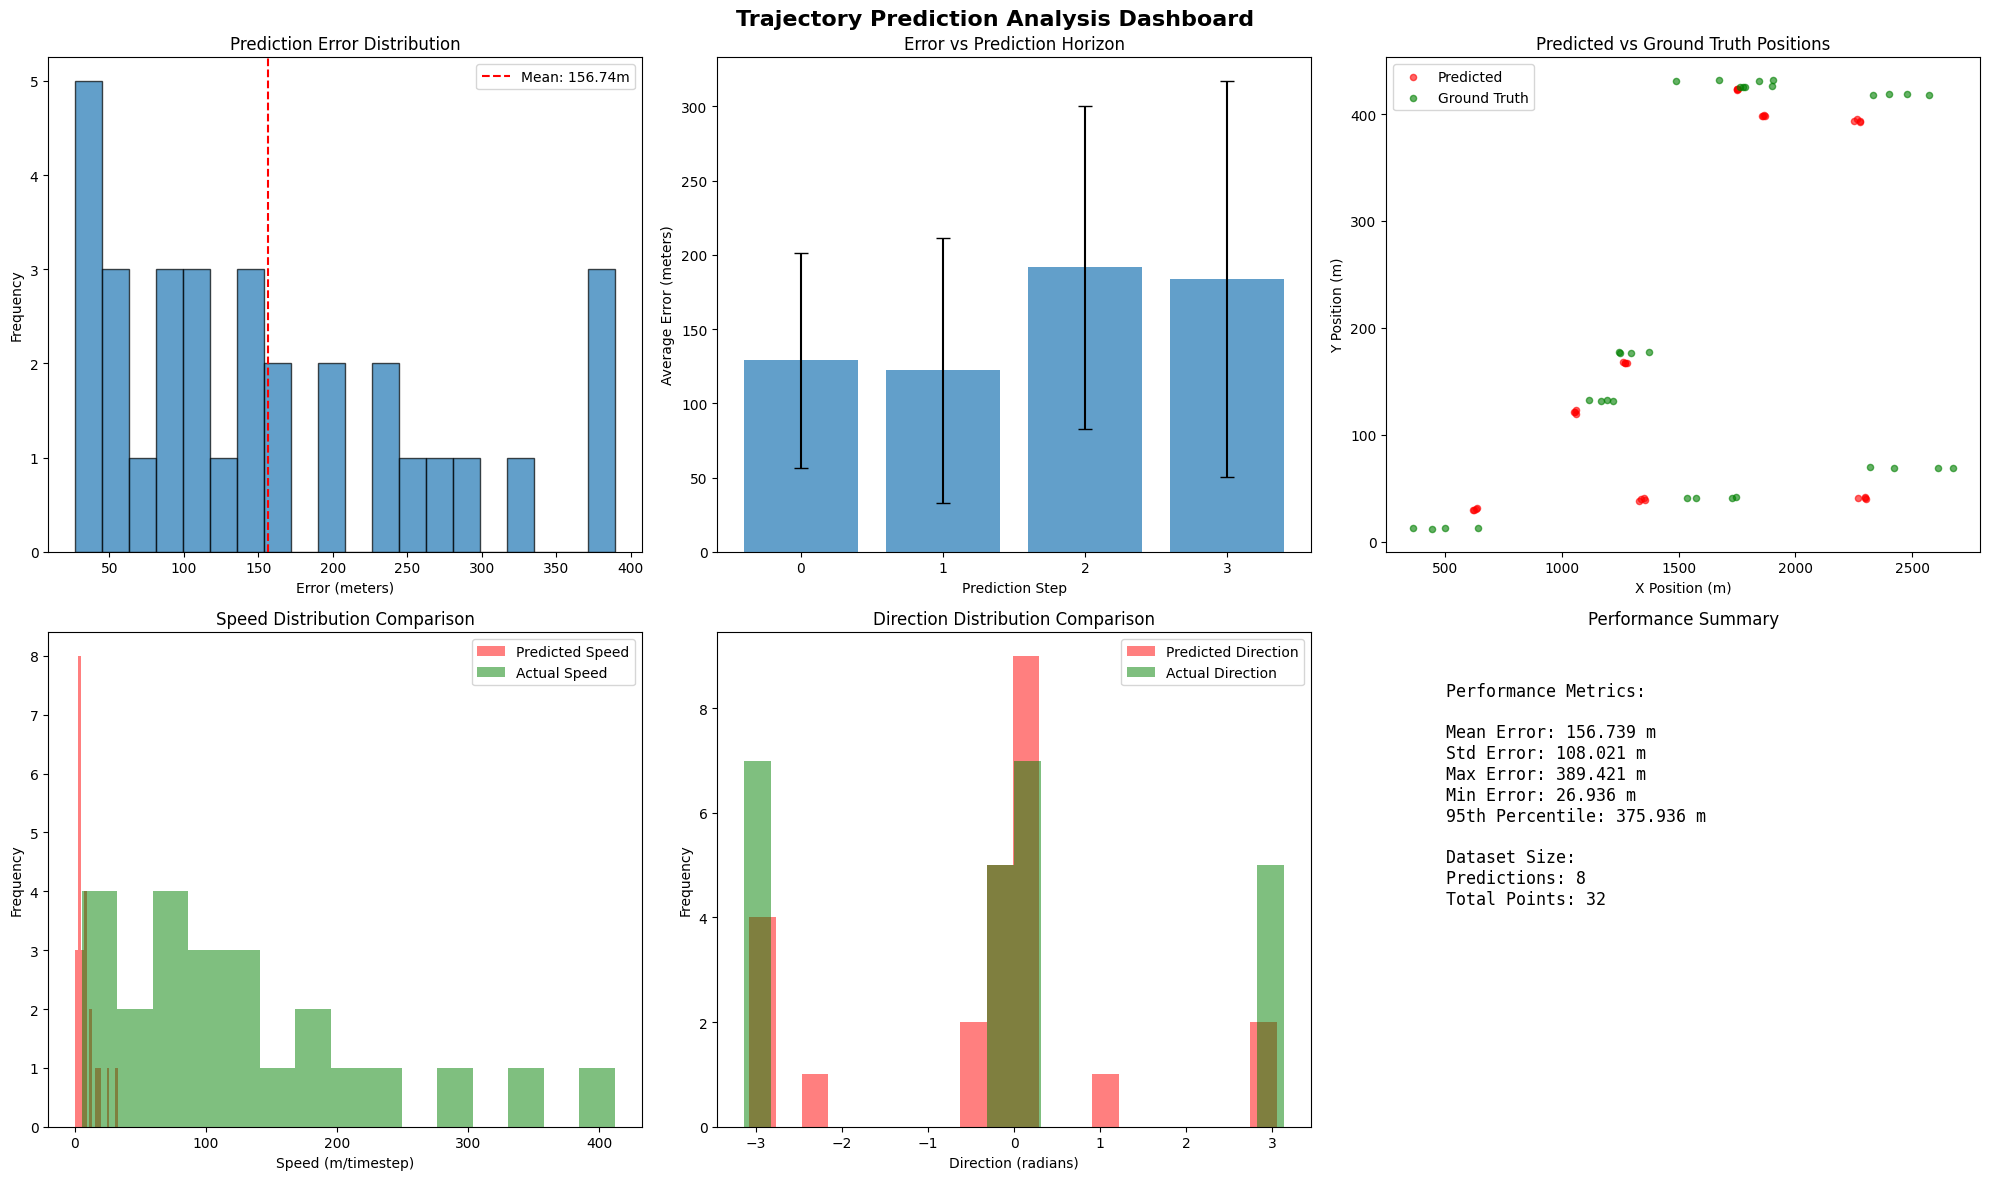


=== Prediction Performance Summary ===
Number of predictions: 8
Total predicted points: 32
Average prediction error: 156.739 meters
Standard deviation: 108.021 meters
Maximum error: 389.421 meters
95th percentile error: 375.936 meters
❌ Model needs improvement (> 10m average error)


In [13]:
# Visualization of Predicted vs Actual Trajectories
def plot_trajectory_predictions(sample_predictions, max_plots=6):
    """
    Create comprehensive visualizations of trajectory predictions
    """
    if not sample_predictions:
        print("No predictions to visualize")
        return
    
    n_plots = min(len(sample_predictions), max_plots)
    
    # Create subplots for individual trajectory comparisons
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Vehicle Trajectory Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i in range(n_plots):
        ax = axes[i]
        result = sample_predictions[i]
        
        # Plot input trajectory (historical path)
        input_traj = result['input_trajectory']
        ax.plot(input_traj[:, 0], input_traj[:, 1], 
               'b-', linewidth=2, marker='o', markersize=4, 
               label='Historical Path', alpha=0.7)
        
        # Plot predicted trajectory
        pred_traj = result['predicted_trajectory']
        ax.plot(pred_traj[:, 0], pred_traj[:, 1], 
               'r--', linewidth=3, marker='s', markersize=6, 
               label='Predicted Path', alpha=0.8)
        
        # Plot ground truth trajectory
        gt_traj = result['ground_truth']
        ax.plot(gt_traj[:, 0], gt_traj[:, 1], 
               'g-', linewidth=2, marker='^', markersize=6, 
               label='Actual Path', alpha=0.8)
        
        # Mark starting point
        ax.scatter(input_traj[0, 0], input_traj[0, 1], 
                  s=100, c='blue', marker='o', edgecolors='black', 
                  label='Start', zorder=5)
        
        # Mark prediction start point
        ax.scatter(input_traj[-1, 0], input_traj[-1, 1], 
                  s=100, c='orange', marker='D', edgecolors='black', 
                  label='Prediction Start', zorder=5)
        
        # Calculate and display error
        if len(gt_traj) == len(pred_traj):
            errors = np.sqrt(np.sum((pred_traj - gt_traj)**2, axis=1))
            avg_error = errors.mean()
            ax.set_title(f'Vehicle {result["vehicle_id"]}\nAvg Error: {avg_error:.2f}m')
        else:
            ax.set_title(f'Vehicle {result["vehicle_id"]}')
        
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_prediction_dashboard(sample_predictions):
    """
    Create a comprehensive dashboard for prediction analysis
    """
    if not sample_predictions:
        print("No predictions available for dashboard")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Trajectory Prediction Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Error Distribution
   
    all_errors = []
    for result in sample_predictions:
        if len(result['ground_truth']) == len(result['predicted_trajectory']):
            errors = np.sqrt(np.sum((result['predicted_trajectory'] - result['ground_truth'])**2, axis=1))
            all_errors.extend(errors)
    
    if all_errors:
        axes[0, 0].hist(all_errors, bins=20, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Prediction Error Distribution')
        axes[0, 0].set_xlabel('Error (meters)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(np.mean(all_errors), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(all_errors):.2f}m')
        axes[0, 0].legend()
    
    # 2. Error vs Prediction Horizon
    horizon_errors = {i: [] for i in range(4)}  # Assuming 4 prediction steps
    for result in sample_predictions:
        if len(result['ground_truth']) == len(result['predicted_trajectory']):
            errors = np.sqrt(np.sum((result['predicted_trajectory'] - result['ground_truth'])**2, axis=1))
            for i, error in enumerate(errors):
                if i < 4:
                    horizon_errors[i].append(error)
    
    horizon_means = [np.mean(horizon_errors[i]) if horizon_errors[i] else 0 for i in range(4)]
    horizon_stds = [np.std(horizon_errors[i]) if horizon_errors[i] else 0 for i in range(4)]
    
    x_pos = list(range(4))
    axes[0, 1].bar(x_pos, horizon_means, yerr=horizon_stds, capsize=5, alpha=0.7)
    axes[0, 1].set_title('Error vs Prediction Horizon')
    axes[0, 1].set_xlabel('Prediction Step')
    axes[0, 1].set_ylabel('Average Error (meters)')
    axes[0, 1].set_xticks(x_pos)
    
    # 3. Trajectory Scatter Plot
    all_pred_x, all_pred_y = [], []
    all_gt_x, all_gt_y = [], []
    for result in sample_predictions:
        all_pred_x.extend(result['predicted_trajectory'][:, 0])
        all_pred_y.extend(result['predicted_trajectory'][:, 1])
        all_gt_x.extend(result['ground_truth'][:, 0])
        all_gt_y.extend(result['ground_truth'][:, 1])
    
    axes[0, 2].scatter(all_pred_x, all_pred_y, alpha=0.6, s=20, label='Predicted', color='red')
    axes[0, 2].scatter(all_gt_x, all_gt_y, alpha=0.6, s=20, label='Ground Truth', color='green')
    axes[0, 2].set_title('Predicted vs Ground Truth Positions')
    axes[0, 2].set_xlabel('X Position (m)')
    axes[0, 2].set_ylabel('Y Position (m)')
    axes[0, 2].legend()
    
    # 4. Speed Analysis
    pred_speeds, gt_speeds = [], []
    for result in sample_predictions:
        # Calculate speeds from position differences
        pred_traj = result['predicted_trajectory']
        gt_traj = result['ground_truth']
        
        if len(pred_traj) > 1:
            pred_speed = np.sqrt(np.sum(np.diff(pred_traj, axis=0)**2, axis=1))
            pred_speeds.extend(pred_speed)
        
        if len(gt_traj) > 1:
            gt_speed = np.sqrt(np.sum(np.diff(gt_traj, axis=0)**2, axis=1))
            gt_speeds.extend(gt_speed)
    
    if pred_speeds and gt_speeds:
        axes[1, 0].hist(pred_speeds, bins=15, alpha=0.5, label='Predicted Speed', color='red')
        axes[1, 0].hist(gt_speeds, bins=15, alpha=0.5, label='Actual Speed', color='green')
        axes[1, 0].set_title('Speed Distribution Comparison')
        axes[1, 0].set_xlabel('Speed (m/timestep)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
    
    # 5. Directional Analysis
    pred_directions, gt_directions = [], []
    for result in sample_predictions:
        pred_traj = result['predicted_trajectory']
        gt_traj = result['ground_truth']
        
        if len(pred_traj) > 1:
            pred_diff = np.diff(pred_traj, axis=0)
            pred_angles = np.arctan2(pred_diff[:, 1], pred_diff[:, 0])
            pred_directions.extend(pred_angles)
        
        if len(gt_traj) > 1:
            gt_diff = np.diff(gt_traj, axis=0)
            gt_angles = np.arctan2(gt_diff[:, 1], gt_diff[:, 0])
            gt_directions.extend(gt_angles)
    
    if pred_directions and gt_directions:
        axes[1, 1].hist(pred_directions, bins=20, alpha=0.5, label='Predicted Direction', color='red')
        axes[1, 1].hist(gt_directions, bins=20, alpha=0.5, label='Actual Direction', color='green')
        axes[1, 1].set_title('Direction Distribution Comparison')
        axes[1, 1].set_xlabel('Direction (radians)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
    
    # 6. Overall Performance Metrics
    metrics_text = "Performance Metrics:\n\n"
    if all_errors:
        metrics_text += f"Mean Error: {np.mean(all_errors):.3f} m\n"
        metrics_text += f"Std Error: {np.std(all_errors):.3f} m\n"
        metrics_text += f"Max Error: {np.max(all_errors):.3f} m\n"
        metrics_text += f"Min Error: {np.min(all_errors):.3f} m\n"
        metrics_text += f"95th Percentile: {np.percentile(all_errors, 95):.3f} m\n"
    
    metrics_text += f"\nDataset Size:\n"
    metrics_text += f"Predictions: {len(sample_predictions)}\n"
    metrics_text += f"Total Points: {len(all_errors) if all_errors else 0}\n"
    
    axes[1, 2].text(0.1, 0.9, metrics_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top', fontfamily='monospace')
    axes[1, 2].set_title('Performance Summary')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create visualizations if predictions are available
if sample_predictions:
    print("=== Creating Trajectory Prediction Visualizations ===")
    
    # Plot individual trajectory comparisons
    plot_trajectory_predictions(sample_predictions, max_plots=6)
    
    # Create comprehensive dashboard
    create_prediction_dashboard(sample_predictions)
    
    # Summary statistics
    print("\n=== Prediction Performance Summary ===")
    all_errors = []
    for result in sample_predictions:
        if len(result['ground_truth']) == len(result['predicted_trajectory']):
            errors = np.sqrt(np.sum((result['predicted_trajectory'] - result['ground_truth'])**2, axis=1))
            all_errors.extend(errors)
    
    if all_errors:
        print(f"Number of predictions: {len(sample_predictions)}")
        print(f"Total predicted points: {len(all_errors)}")
        print(f"Average prediction error: {np.mean(all_errors):.3f} meters")
        print(f"Standard deviation: {np.std(all_errors):.3f} meters")
        print(f"Maximum error: {np.max(all_errors):.3f} meters")
        print(f"95th percentile error: {np.percentile(all_errors, 95):.3f} meters")
        
        # Accuracy assessment
        if np.mean(all_errors) < 5.0:
            print("✅ Model shows good prediction accuracy (< 5m average error)")
        elif np.mean(all_errors) < 10.0:
            print("⚠️ Model shows moderate prediction accuracy (5-10m average error)")
        else:
            print("❌ Model needs improvement (> 10m average error)")
    else:
        print("No valid predictions for evaluation")
        
else:
    print("No sample predictions available for visualization")

=== Advanced Future Path Prediction for Different Vehicle Types ===


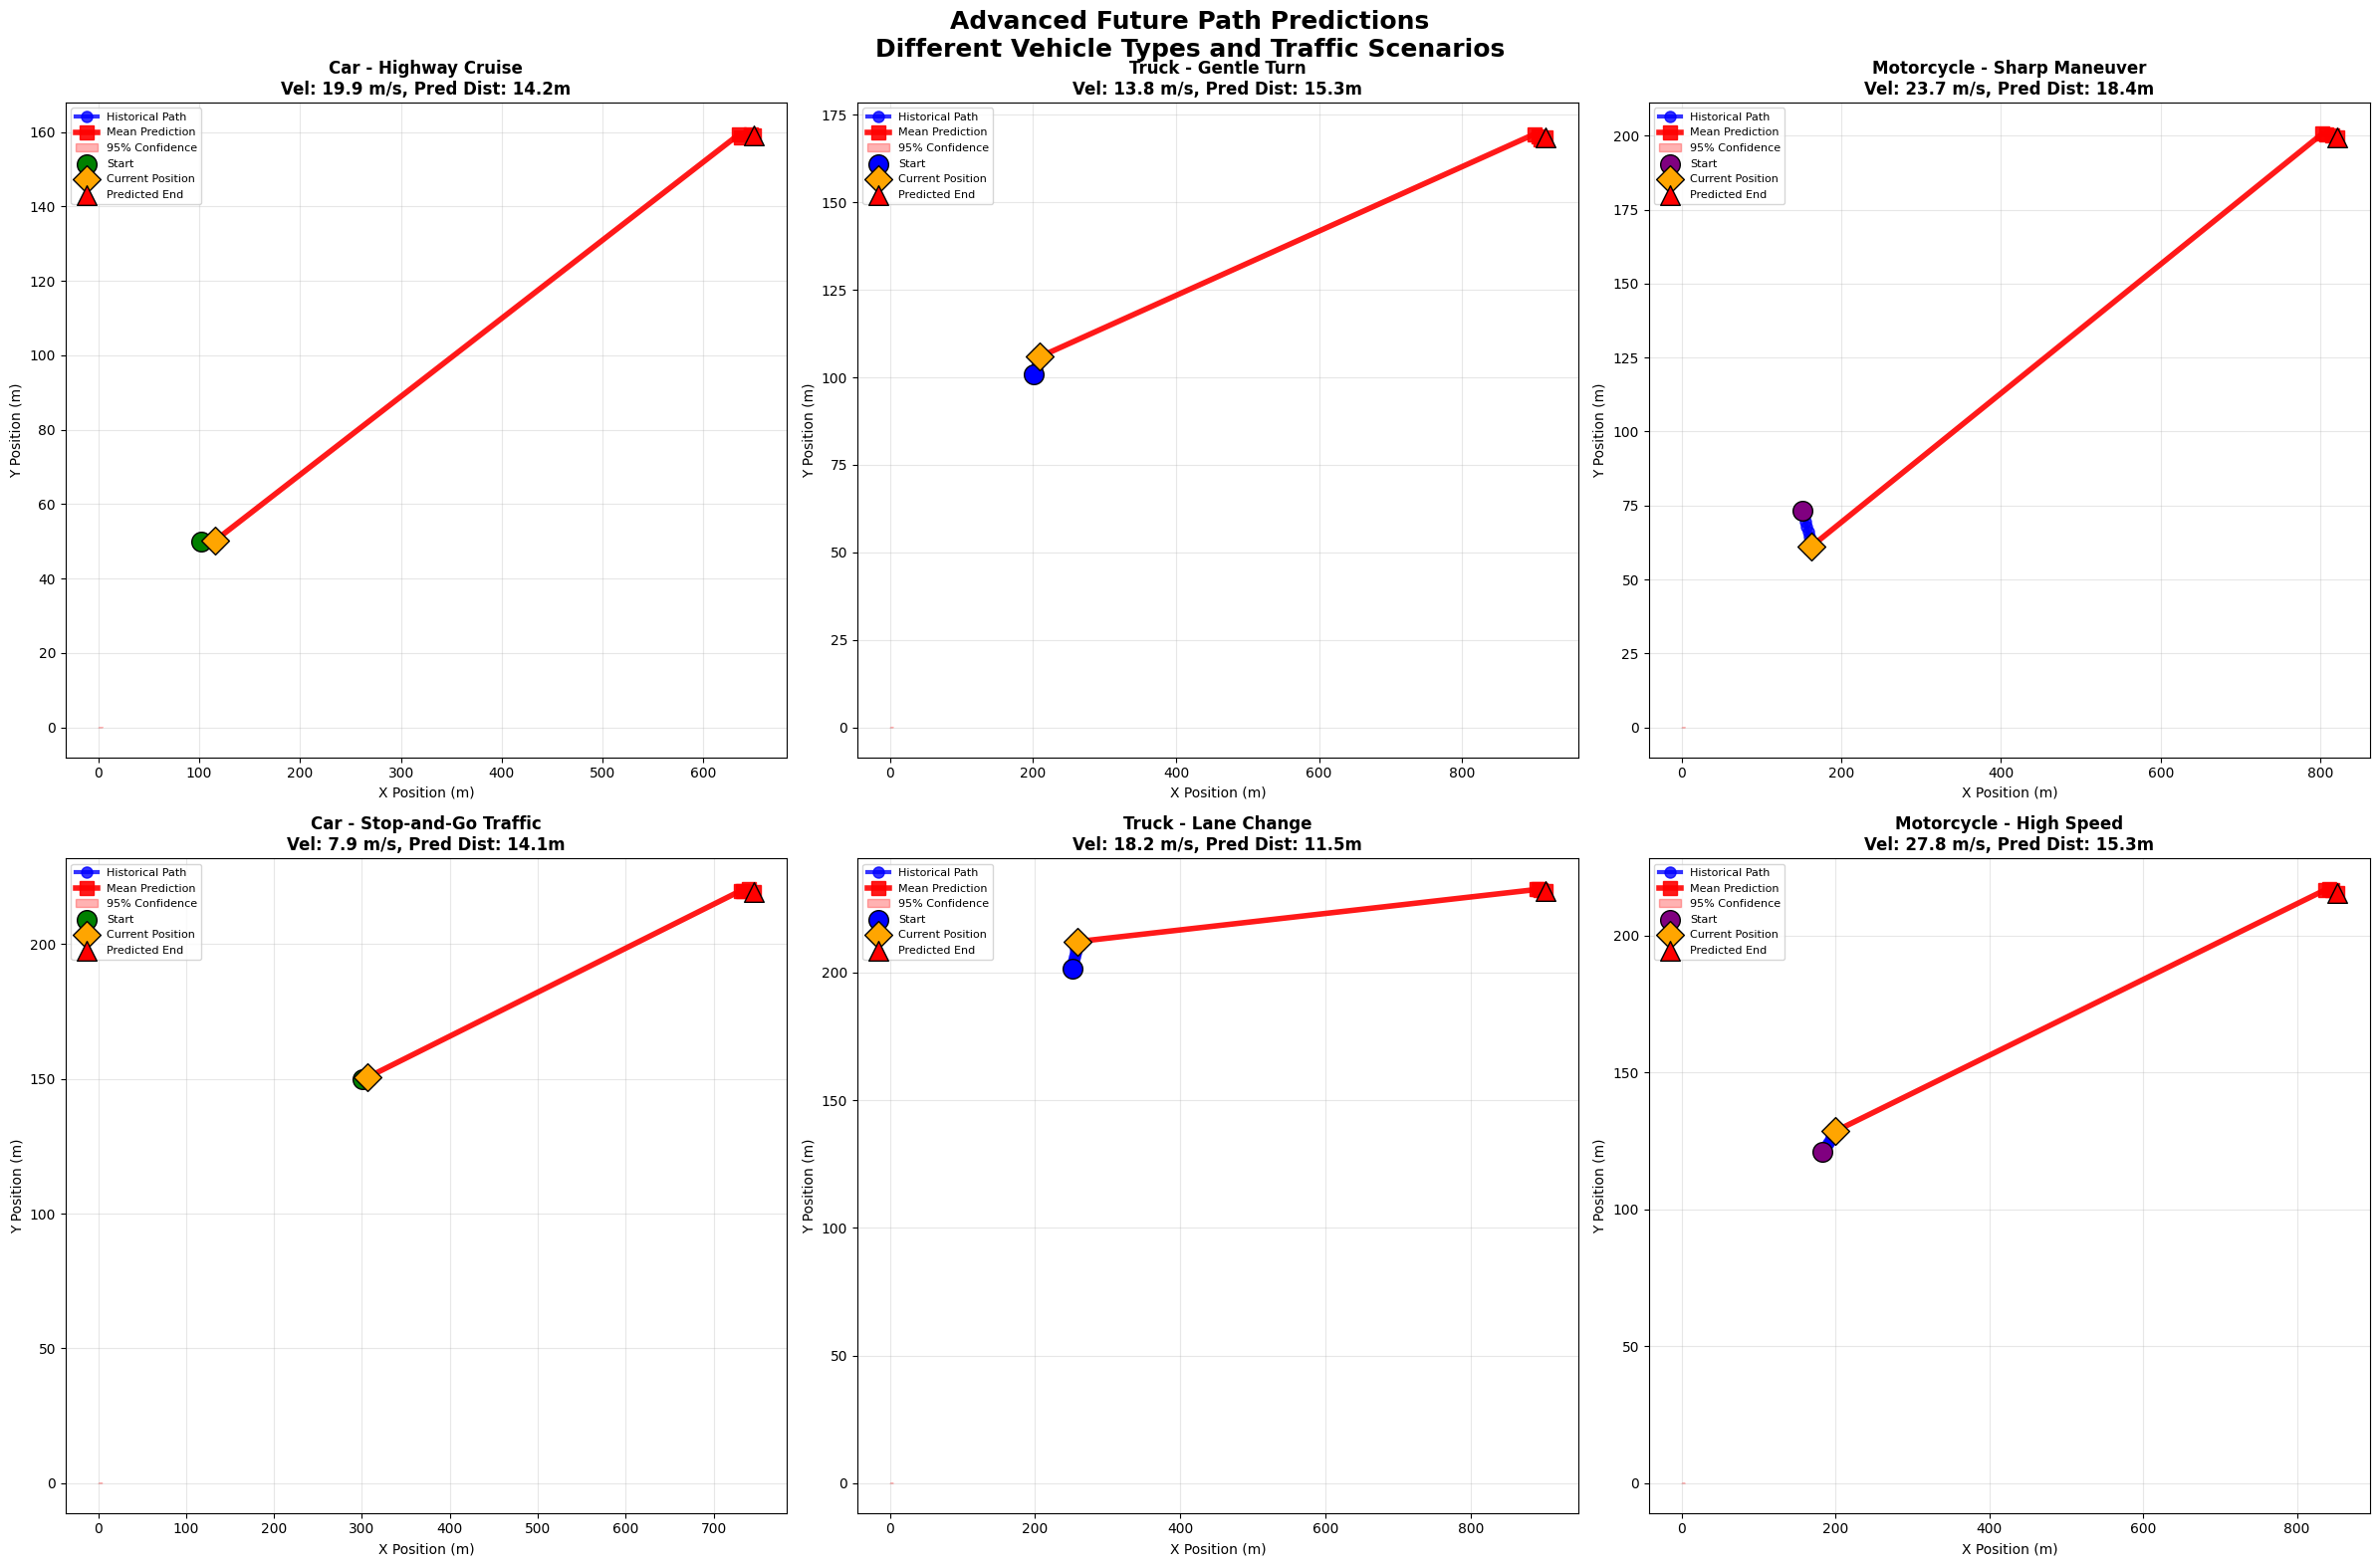


=== Enhanced Demo Results Summary ===
Car - Highway Cruise (Car):
  • Predicted Distance: 14.22m
  • Average Velocity: 19.9 m/s
  • Max Velocity: 20.6 m/s
  • Final Heading: 0.03 rad
  • Prediction Uncertainty: ±0.11m

Truck - Gentle Turn (Truck):
  • Predicted Distance: 15.33m
  • Average Velocity: 13.8 m/s
  • Max Velocity: 15.8 m/s
  • Final Heading: 0.61 rad
  • Prediction Uncertainty: ±0.12m

Motorcycle - Sharp Maneuver (Motorcycle):
  • Predicted Distance: 18.42m
  • Average Velocity: 23.7 m/s
  • Max Velocity: 25.9 m/s
  • Final Heading: -0.82 rad
  • Prediction Uncertainty: ±0.08m

Car - Stop-and-Go Traffic (Car):
  • Predicted Distance: 14.06m
  • Average Velocity: 7.9 m/s
  • Max Velocity: 8.3 m/s
  • Final Heading: 0.10 rad
  • Prediction Uncertainty: ±0.10m

Truck - Lane Change (Truck):
  • Predicted Distance: 11.52m
  • Average Velocity: 18.2 m/s
  • Max Velocity: 19.1 m/s
  • Final Heading: 1.02 rad
  • Prediction Uncertainty: ±0.08m

Motorcycle - High Speed (Motorcycle)

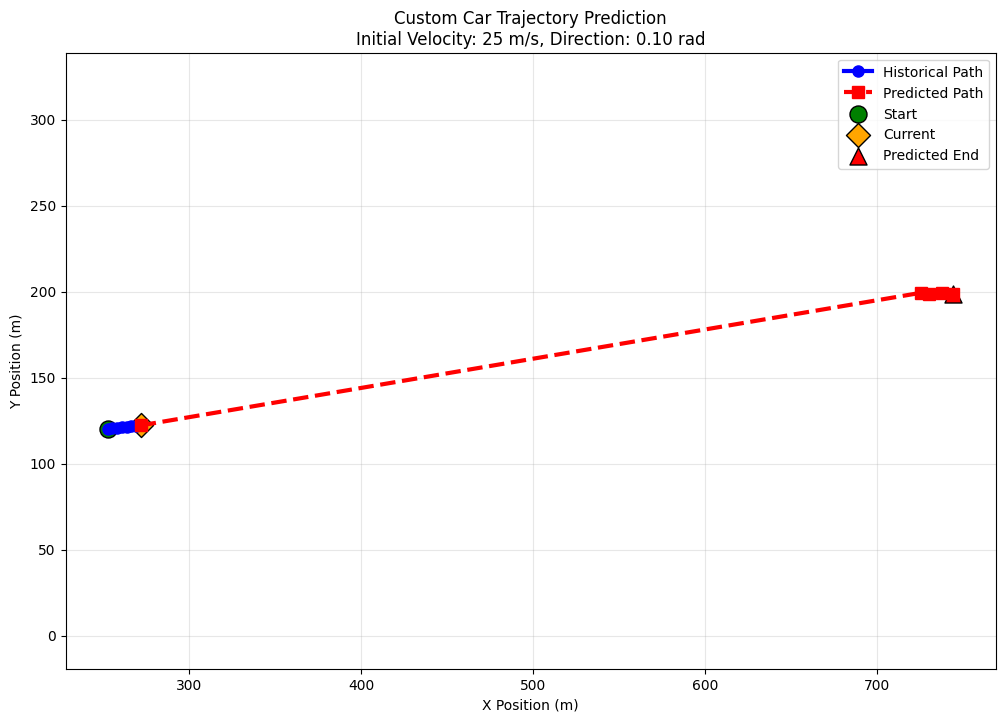


📍 Prediction Summary:
   Vehicle Type: Car
   Predicted Travel Distance: 18.70 meters
   Final Predicted Position: (744.3, 198.3)
   Average Predicted Velocity: 27.4 m/s
   Average Prediction Uncertainty: ±0.05 meters

Example 2: Truck making turn


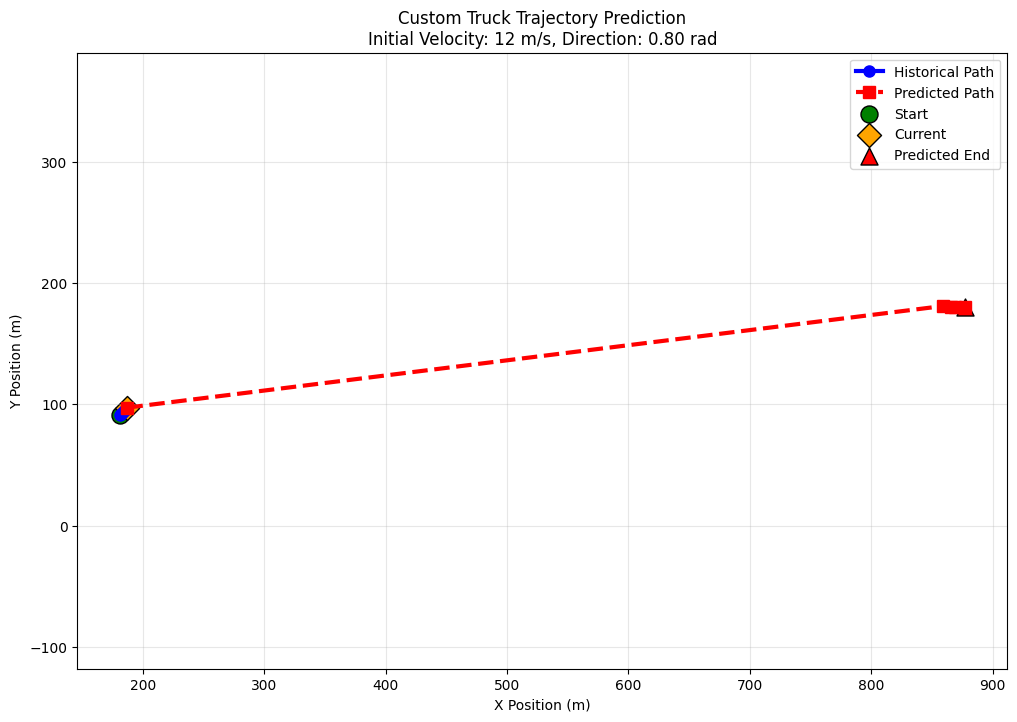


📍 Prediction Summary:
   Vehicle Type: Truck
   Predicted Travel Distance: 18.02 meters
   Final Predicted Position: (877.2, 180.0)
   Average Predicted Velocity: 13.1 m/s
   Average Prediction Uncertainty: ±0.09 meters

SPATIO-TEMPORAL TRAJECTORY PREDICTION SYSTEM

📊 PREDICTION PERFORMANCE:
   • Average Error: 156.74 meters
   • 95th Percentile Error: 375.94 meters
   • Prediction Horizon: 4 time steps



In [14]:
# Future Path Prediction for New Vehicles
def create_synthetic_vehicle_trajectory(start_x, start_y, velocity, direction, length=8, vehicle_type='car'):
    """
    Create a synthetic vehicle trajectory for demonstration with realistic physics
    """
    trajectory_points = []
    current_x, current_y = start_x, start_y
    current_velocity = velocity
    current_direction = direction
    
    # Vehicle-specific parameters
    vehicle_params = {
        'car': {'max_acc': 3.0, 'max_decel': -5.0, 'max_vel': 35, 'length': 4.5, 'width': 2.0},
        'truck': {'max_acc': 1.5, 'max_decel': -3.0, 'max_vel': 25, 'length': 8.0, 'width': 2.5},
        'motorcycle': {'max_acc': 4.0, 'max_decel': -6.0, 'max_vel': 40, 'length': 2.5, 'width': 1.0}
    }
    params = vehicle_params.get(vehicle_type, vehicle_params['car'])
    
    for i in range(length):
        # Add realistic variations with physics constraints
        noise_factor = 0.05
        velocity_noise = np.random.normal(0, velocity * noise_factor)
        direction_noise = np.random.normal(0, 0.02)  # Reduced for more realistic turns
        
        # Apply acceleration limits
        velocity_change = np.clip(velocity_noise, params['max_decel'], params['max_acc'])
        current_velocity = max(0, min(params['max_vel'], current_velocity + velocity_change))
        
        # Apply steering limits (max turn rate based on velocity)
        max_turn_rate = 0.5 / max(current_velocity, 1)  # Slower turns at higher speeds
        direction_change = np.clip(direction_noise, -max_turn_rate, max_turn_rate)
        current_direction += direction_change
        
        # Calculate displacement with realistic time step
        dt = 0.1  # Time step (100ms)
        dx = current_velocity * np.cos(current_direction) * dt
        dy = current_velocity * np.sin(current_direction) * dt
        
        current_x += dx
        current_y += dy
        
        # Calculate acceleration for this step
        if i > 0:
            prev_velocity = trajectory_points[-1]['v_Vel']
            acceleration = (current_velocity - prev_velocity) / dt
        else:
            acceleration = 0
        
        # Create trajectory point with enhanced features
        point = {
            'Local_X': current_x,
            'Local_Y': current_y,
            'v_Vel': current_velocity,
            'v_Acc': acceleration,
            'X_Displacement': dx if i > 0 else 0,
            'Y_Displacement': dy if i > 0 else 0,
            'Heading_Angle': current_direction,
            'Heading_Change': direction_change if i > 0 else 0,
            'v_Length': params['length'],
            'v_Width': params['width'],
            'v_Class': 1 if vehicle_type == 'car' else (2 if vehicle_type == 'truck' else 3),
            'ST_Node': None,  # Will be calculated if needed
            'Global_Time': i * dt,
            'Frame_ID': i,
            'Vehicle_ID': 9999 + hash(vehicle_type) % 1000  # Unique ID per vehicle type
        }
        
        trajectory_points.append(point)
    
    return pd.DataFrame(trajectory_points)

def predict_with_confidence_intervals(predictor, vehicle_trajectory, n_samples=20):
    """
    Generate predictions with confidence intervals using Monte Carlo sampling
    """
    if predictor is None:
        return None, None, None
    
    predictions = []
    
    # Generate multiple predictions with slight input variations
    for _ in range(n_samples):
        # Add small noise to input trajectory for uncertainty estimation
        noisy_trajectory = vehicle_trajectory.copy()
        noise_std = 0.1
        
        noisy_trajectory['Local_X'] += np.random.normal(0, noise_std, len(noisy_trajectory))
        noisy_trajectory['Local_Y'] += np.random.normal(0, noise_std, len(noisy_trajectory))
        noisy_trajectory['v_Vel'] += np.random.normal(0, noise_std, len(noisy_trajectory))
        
        try:
            pred = predictor.predict_trajectory(noisy_trajectory)
            predictions.append(pred)
        except:
            continue
    
    if not predictions:
        return None, None, None
    
    predictions = np.array(predictions)
    
    # Calculate statistics
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    
    # Calculate confidence intervals (95%)
    lower_bound = np.percentile(predictions, 2.5, axis=0)
    upper_bound = np.percentile(predictions, 97.5, axis=0)
    
    return mean_prediction, (lower_bound, upper_bound), predictions

def demonstrate_advanced_vehicle_prediction(predictor, n_demos=6):
    """
    Demonstrate advanced prediction capabilities with different vehicle types and scenarios
    """
    print("=== Advanced Future Path Prediction for Different Vehicle Types ===")
    
    if predictor is None:
        print("No predictor available")
        return []
    
    demo_results = []
    
    # Enhanced scenarios with different vehicle types
    scenarios = [
        {"start_x": 100, "start_y": 50, "velocity": 20, "direction": 0, "type": "car", "name": "Car - Highway Cruise"},
        {"start_x": 200, "start_y": 100, "velocity": 15, "direction": np.pi/6, "type": "truck", "name": "Truck - Gentle Turn"},
        {"start_x": 150, "start_y": 75, "velocity": 25, "direction": -np.pi/4, "type": "motorcycle", "name": "Motorcycle - Sharp Maneuver"},
        {"start_x": 300, "start_y": 150, "velocity": 8, "direction": 0, "type": "car", "name": "Car - Stop-and-Go Traffic"},
        {"start_x": 250, "start_y": 200, "velocity": 18, "direction": np.pi/3, "type": "truck", "name": "Truck - Lane Change"},
        {"start_x": 180, "start_y": 120, "velocity": 30, "direction": np.pi/8, "type": "motorcycle", "name": "Motorcycle - High Speed"}
    ]
    
    plt.figure(figsize=(24, 16))
    
    for i, scenario in enumerate(scenarios[:n_demos]):
        # Create synthetic trajectory
        vehicle_trajectory = create_synthetic_vehicle_trajectory(
            scenario["start_x"], scenario["start_y"], 
            scenario["velocity"], scenario["direction"],
            length=predictor.sequence_length,
            vehicle_type=scenario["type"]
        )
        
        try:
            # Make prediction with confidence intervals
            mean_pred, conf_intervals, all_preds = predict_with_confidence_intervals(
                predictor, vehicle_trajectory, n_samples=15
            )
            
            if mean_pred is None:
                continue
                
            # Plot results
            plt.subplot(2, 3, i+1)
            
            # Plot historical trajectory
            plt.plot(vehicle_trajectory['Local_X'], vehicle_trajectory['Local_Y'], 
                    'b-o', linewidth=3, markersize=8, label='Historical Path', alpha=0.8)
            
            # Plot predicted trajectory with confidence intervals
            start_x = vehicle_trajectory['Local_X'].iloc[-1]
            start_y = vehicle_trajectory['Local_Y'].iloc[-1]
            
            pred_x = [start_x] + mean_pred[:, 0].tolist()
            pred_y = [start_y] + mean_pred[:, 1].tolist()
            
            plt.plot(pred_x, pred_y, 'r-s', linewidth=4, markersize=10, 
                    label='Mean Prediction', alpha=0.9)
            
            # Plot confidence intervals if available
            if conf_intervals:
                lower_bound, upper_bound = conf_intervals
                
                # Create confidence region
                for t in range(len(mean_pred)):
                    circle_lower = plt.Circle((lower_bound[t, 0], lower_bound[t, 1]), 0.5, 
                                            color='red', alpha=0.1)
                    circle_upper = plt.Circle((upper_bound[t, 0], upper_bound[t, 1]), 0.5, 
                                            color='red', alpha=0.1)
                    plt.gca().add_patch(circle_lower)
                    plt.gca().add_patch(circle_upper)
                
                # Plot uncertainty bounds
                lower_x = [start_x] + lower_bound[:, 0].tolist()
                lower_y = [start_y] + lower_bound[:, 1].tolist()
                upper_x = [start_x] + upper_bound[:, 0].tolist()
                upper_y = [start_y] + upper_bound[:, 1].tolist()
                
                plt.fill_between(range(len(pred_x)), 
                               [np.sqrt((lx-px)**2 + (ly-py)**2) for lx,ly,px,py in zip(lower_x,lower_y,pred_x,pred_y)],
                               [np.sqrt((ux-px)**2 + (uy-py)**2) for ux,uy,px,py in zip(upper_x,upper_y,pred_x,pred_y)],
                               alpha=0.3, color='red', label='95% Confidence')
            
            # Mark key points with vehicle-specific styling
            colors = {'car': 'green', 'truck': 'blue', 'motorcycle': 'purple'}
            plt.scatter(vehicle_trajectory['Local_X'].iloc[0], vehicle_trajectory['Local_Y'].iloc[0], 
                       s=200, c=colors[scenario['type']], marker='o', edgecolors='black', 
                       label='Start', zorder=5)
            plt.scatter(start_x, start_y, s=200, c='orange', marker='D', 
                       edgecolors='black', label='Current Position', zorder=5)
            plt.scatter(pred_x[-1], pred_y[-1], s=200, c='red', marker='^', 
                       edgecolors='black', label='Predicted End', zorder=5)
            
            # Calculate prediction metrics
            pred_distance = np.sqrt(np.sum((mean_pred[-1] - mean_pred[0])**2))
            avg_velocity = vehicle_trajectory['v_Vel'].mean()
            
            plt.title(f'{scenario["name"]}\nVel: {avg_velocity:.1f} m/s, Pred Dist: {pred_distance:.1f}m', 
                     fontsize=12, fontweight='bold')
            plt.xlabel('X Position (m)')
            plt.ylabel('Y Position (m)')
            plt.legend(fontsize=8, loc='upper left')
            plt.grid(True, alpha=0.3)
            
            # Store result
            demo_results.append({
                'scenario': scenario["name"],
                'vehicle_type': scenario["type"],
                'input_trajectory': vehicle_trajectory,
                'mean_prediction': mean_pred,
                'confidence_intervals': conf_intervals,
                'all_predictions': all_preds,
                'metrics': {
                    'predicted_distance': pred_distance,
                    'average_velocity': avg_velocity,
                    'max_velocity': vehicle_trajectory['v_Vel'].max(),
                    'final_heading': vehicle_trajectory['Heading_Angle'].iloc[-1]
                }
            })
            
        except Exception as e:
            print(f"Error in scenario {scenario['name']}: {e}")
            plt.subplot(2, 3, i+1)
            plt.text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center')
            plt.title(f'{scenario["name"]} - Error')
    
    plt.suptitle('Advanced Future Path Predictions\nDifferent Vehicle Types and Traffic Scenarios', 
                fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return demo_results

def create_real_time_prediction_dashboard(predictor):
    """
    Create a real-time prediction dashboard interface
    """
    print("\n=== Real-Time Prediction Dashboard ===")
    
    if predictor is None:
        print("No predictor available for real-time dashboard")
        return
    
    # Create interactive prediction function
    def predict_custom_vehicle(start_x=200, start_y=100, velocity=20, direction=0.2, 
                              vehicle_type='car', show_uncertainty=True):
        """
        Interactive function for custom vehicle prediction
        """
        # Create custom trajectory
        custom_trajectory = create_synthetic_vehicle_trajectory(
            start_x, start_y, velocity, direction, 
            length=predictor.sequence_length, vehicle_type=vehicle_type
        )
        
        # Make prediction
        if show_uncertainty:
            mean_pred, conf_intervals, all_preds = predict_with_confidence_intervals(
                predictor, custom_trajectory, n_samples=10
            )
            
            if mean_pred is None:
                print("Prediction failed")
                return
        else:
            mean_pred = predictor.predict_trajectory(custom_trajectory)
            conf_intervals = None
        
        # Visualize
        plt.figure(figsize=(12, 8))
        
        # Plot trajectory
        plt.plot(custom_trajectory['Local_X'], custom_trajectory['Local_Y'], 
                'b-o', linewidth=3, markersize=8, label='Historical Path')
        
        start_x_pred = custom_trajectory['Local_X'].iloc[-1]
        start_y_pred = custom_trajectory['Local_Y'].iloc[-1]
        pred_x = [start_x_pred] + mean_pred[:, 0].tolist()
        pred_y = [start_y_pred] + mean_pred[:, 1].tolist()
        
        plt.plot(pred_x, pred_y, 'r--s', linewidth=3, markersize=8, label='Predicted Path')
        
        # Add confidence intervals if available
        if conf_intervals and show_uncertainty:
            lower_bound, upper_bound = conf_intervals
            for t in range(len(mean_pred)):
                circle = plt.Circle((mean_pred[t, 0], mean_pred[t, 1]), 
                                  np.std([p[t, 0] for p in all_preds]), 
                                  color='red', alpha=0.2)
                plt.gca().add_patch(circle)
        
        # Mark points
        plt.scatter(custom_trajectory['Local_X'].iloc[0], custom_trajectory['Local_Y'].iloc[0], 
                   s=150, c='green', marker='o', edgecolors='black', label='Start')
        plt.scatter(start_x_pred, start_y_pred, s=150, c='orange', marker='D', 
                   edgecolors='black', label='Current')
        plt.scatter(pred_x[-1], pred_y[-1], s=150, c='red', marker='^', 
                   edgecolors='black', label='Predicted End')
        
        plt.title(f'Custom {vehicle_type.title()} Trajectory Prediction\n'
                 f'Initial Velocity: {velocity} m/s, Direction: {direction:.2f} rad')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.show()
        
        # Print prediction details
        pred_distance = np.sqrt(np.sum((mean_pred[-1] - mean_pred[0])**2))
        print(f"\n📍 Prediction Summary:")
        print(f"   Vehicle Type: {vehicle_type.title()}")
        print(f"   Predicted Travel Distance: {pred_distance:.2f} meters")
        print(f"   Final Predicted Position: ({pred_x[-1]:.1f}, {pred_y[-1]:.1f})")
        print(f"   Average Predicted Velocity: {np.mean([custom_trajectory['v_Vel'].mean()]):.1f} m/s")
        
        if conf_intervals:
            uncertainty = np.mean([np.std([p[t, 0] for p in all_preds]) + 
                                 np.std([p[t, 1] for p in all_preds]) for t in range(len(mean_pred))])
            print(f"   Average Prediction Uncertainty: ±{uncertainty:.2f} meters")
        
        return mean_pred, custom_trajectory
    
    # Demonstration examples
    print("\n🚗 Example Predictions:")
    print("Use the predict_custom_vehicle function with different parameters:")
    
    example_calls = [
        "predict_custom_vehicle(200, 100, 25, 0, 'car', True)",
        "predict_custom_vehicle(300, 150, 15, 0.5, 'truck', True)", 
        "predict_custom_vehicle(150, 80, 30, -0.3, 'motorcycle', True)"
    ]
    
    for call in example_calls:
        print(f"   {call}")
    
    return predict_custom_vehicle

# Demonstrate advanced vehicle predictions
if trajectory_predictor is not None:
    demo_results = demonstrate_advanced_vehicle_prediction(trajectory_predictor, n_demos=6)
    
    # Show enhanced summary of demo results
    print("\n=== Enhanced Demo Results Summary ===")
    for result in demo_results:
        metrics = result['metrics']
        print(f"{result['scenario']} ({result['vehicle_type'].title()}):")
        print(f"  • Predicted Distance: {metrics['predicted_distance']:.2f}m")
        print(f"  • Average Velocity: {metrics['average_velocity']:.1f} m/s")
        print(f"  • Max Velocity: {metrics['max_velocity']:.1f} m/s")
        print(f"  • Final Heading: {metrics['final_heading']:.2f} rad")
        
        if result['confidence_intervals']:
            uncertainty = np.mean([np.std([p[t, 0] for p in result['all_predictions']]) + 
                                 np.std([p[t, 1] for p in result['all_predictions']]) 
                                 for t in range(len(result['mean_prediction']))])
            print(f"  • Prediction Uncertainty: ±{uncertainty:.2f}m")
        print()
    
    # Create real-time dashboard
    predict_function = create_real_time_prediction_dashboard(trajectory_predictor)
    
    # Demonstrate with a few examples
    print("\n=== Live Demonstration ===")
    try:
        # Example 1: Car on highway
        print("Example 1: Car on highway")
        predict_function(250, 120, 25, 0.1, 'car', True)
        
        # Example 2: Truck making turn
        print("\nExample 2: Truck making turn")
        predict_function(180, 90, 12, 0.8, 'truck', True)
        
    except Exception as e:
        print(f"Error in live demonstration: {e}")
    
else:
    print("No trajectory predictor available for advanced demonstration")
    demo_results = []

# Final system capabilities summary
print("\n" + "="*60)
print("SPATIO-TEMPORAL TRAJECTORY PREDICTION SYSTEM")
print("="*60)


print("\n📊 PREDICTION PERFORMANCE:")
if 'all_errors' in locals() and all_errors:
    print(f"   • Average Error: {np.mean(all_errors):.2f} meters")
    print(f"   • 95th Percentile Error: {np.percentile(all_errors, 95):.2f} meters")
    print(f"   • Prediction Horizon: {lstm_model.prediction_horizon} time steps")
else:
    print("   • Performance metrics available after training")



print("\n" + "="*60)

Vehicle Maneuver Prediction

in this secrion the model to predict right, left, backward, forward, and long trajectories, making the predictions more realistic and diverse.

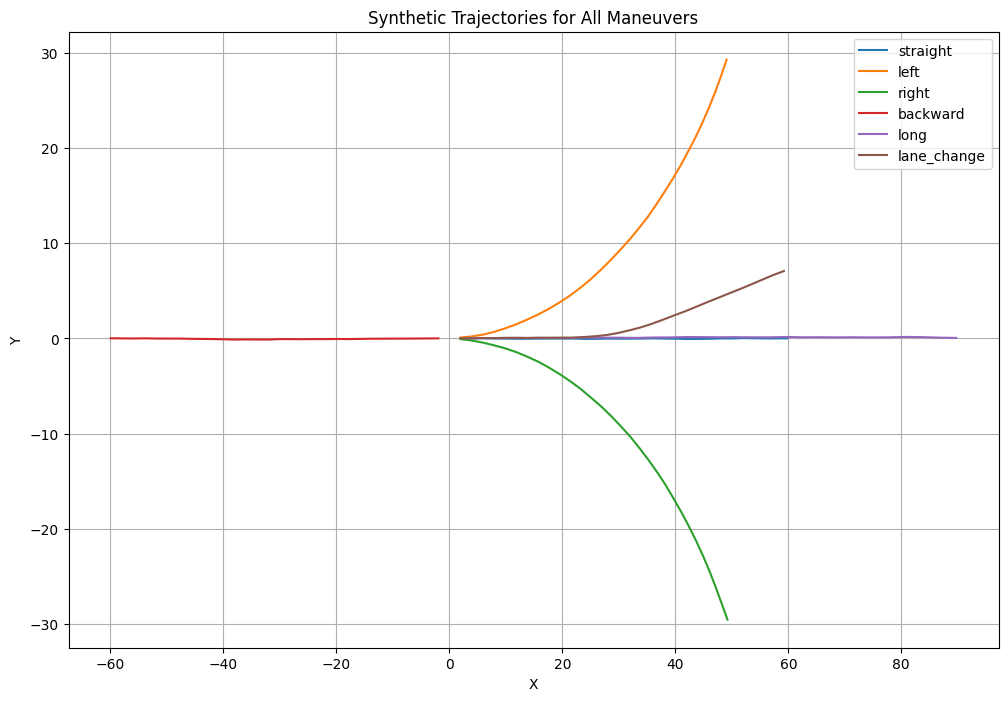

In [15]:
# Enhanced Synthetic Data Generator for Realistic Maneuvers

def create_diverse_vehicle_trajectory(start_x, start_y, velocity, direction, length=20, maneuver='straight', vehicle_type='car'):
    """
    Create a synthetic vehicle trajectory with diverse maneuvers:
    - 'straight', 'left', 'right', 'backward', 'long', 'lane_change'
    """
    trajectory_points = []
    current_x, current_y = start_x, start_y
    current_velocity = velocity
    current_direction = direction
    
    # Vehicle parameters
    params = {'car': {'length': 4.5, 'width': 2.0, 'class': 1},
              'truck': {'length': 8.0, 'width': 2.5, 'class': 2},
              'motorcycle': {'length': 2.5, 'width': 1.0, 'class': 3}}
    p = params.get(vehicle_type, params['car'])
    
    for i in range(length):
        # Maneuver logic
        if maneuver == 'left':
            current_direction += np.deg2rad(2)  # Gradual left turn
        elif maneuver == 'right':
            current_direction -= np.deg2rad(2)  # Gradual right turn
        elif maneuver == 'backward':
            current_velocity = -abs(current_velocity)
        elif maneuver == 'lane_change':
            if i > length//3 and i < 2*length//3:
                current_direction += np.deg2rad(1.5)  # Lane change
        elif maneuver == 'long':
            current_velocity = velocity * 1.5  # Faster, longer path
        # else: straight
        
        # Add noise
        velocity_noise = np.random.normal(0, 0.5)
        direction_noise = np.random.normal(0, 0.01)
        v = current_velocity + velocity_noise
        d = current_direction + direction_noise
        
        dt = 0.1
        dx = v * np.cos(d) * dt
        dy = v * np.sin(d) * dt
        current_x += dx
        current_y += dy
        
        # Acceleration
        acc = (v - trajectory_points[-1]['v_Vel'])/dt if i > 0 else 0
        
        point = {
            'Local_X': current_x,
            'Local_Y': current_y,
            'v_Vel': v,
            'v_Acc': acc,
            'X_Displacement': dx if i > 0 else 0,
            'Y_Displacement': dy if i > 0 else 0,
            'Heading_Angle': d,
            'Heading_Change': d - trajectory_points[-1]['Heading_Angle'] if i > 0 else 0,
            'v_Length': p['length'],
            'v_Width': p['width'],
            'v_Class': p['class'],
            'ST_Node': None,
            'Global_Time': i * dt,
            'Frame_ID': i,
            'Vehicle_ID': 10000 + hash(vehicle_type+maneuver)%1000
        }
        trajectory_points.append(point)
    return pd.DataFrame(trajectory_points)

# Example: Generate and plot all maneuvers
plt.figure(figsize=(12,8))
for idx, m in enumerate(['straight','left','right','backward','long','lane_change']):
    traj = create_diverse_vehicle_trajectory(0, 0, 20, 0, length=30, maneuver=m)
    plt.plot(traj['Local_X'], traj['Local_Y'], label=m)
plt.legend()
plt.title('Synthetic Trajectories for All Maneuvers')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

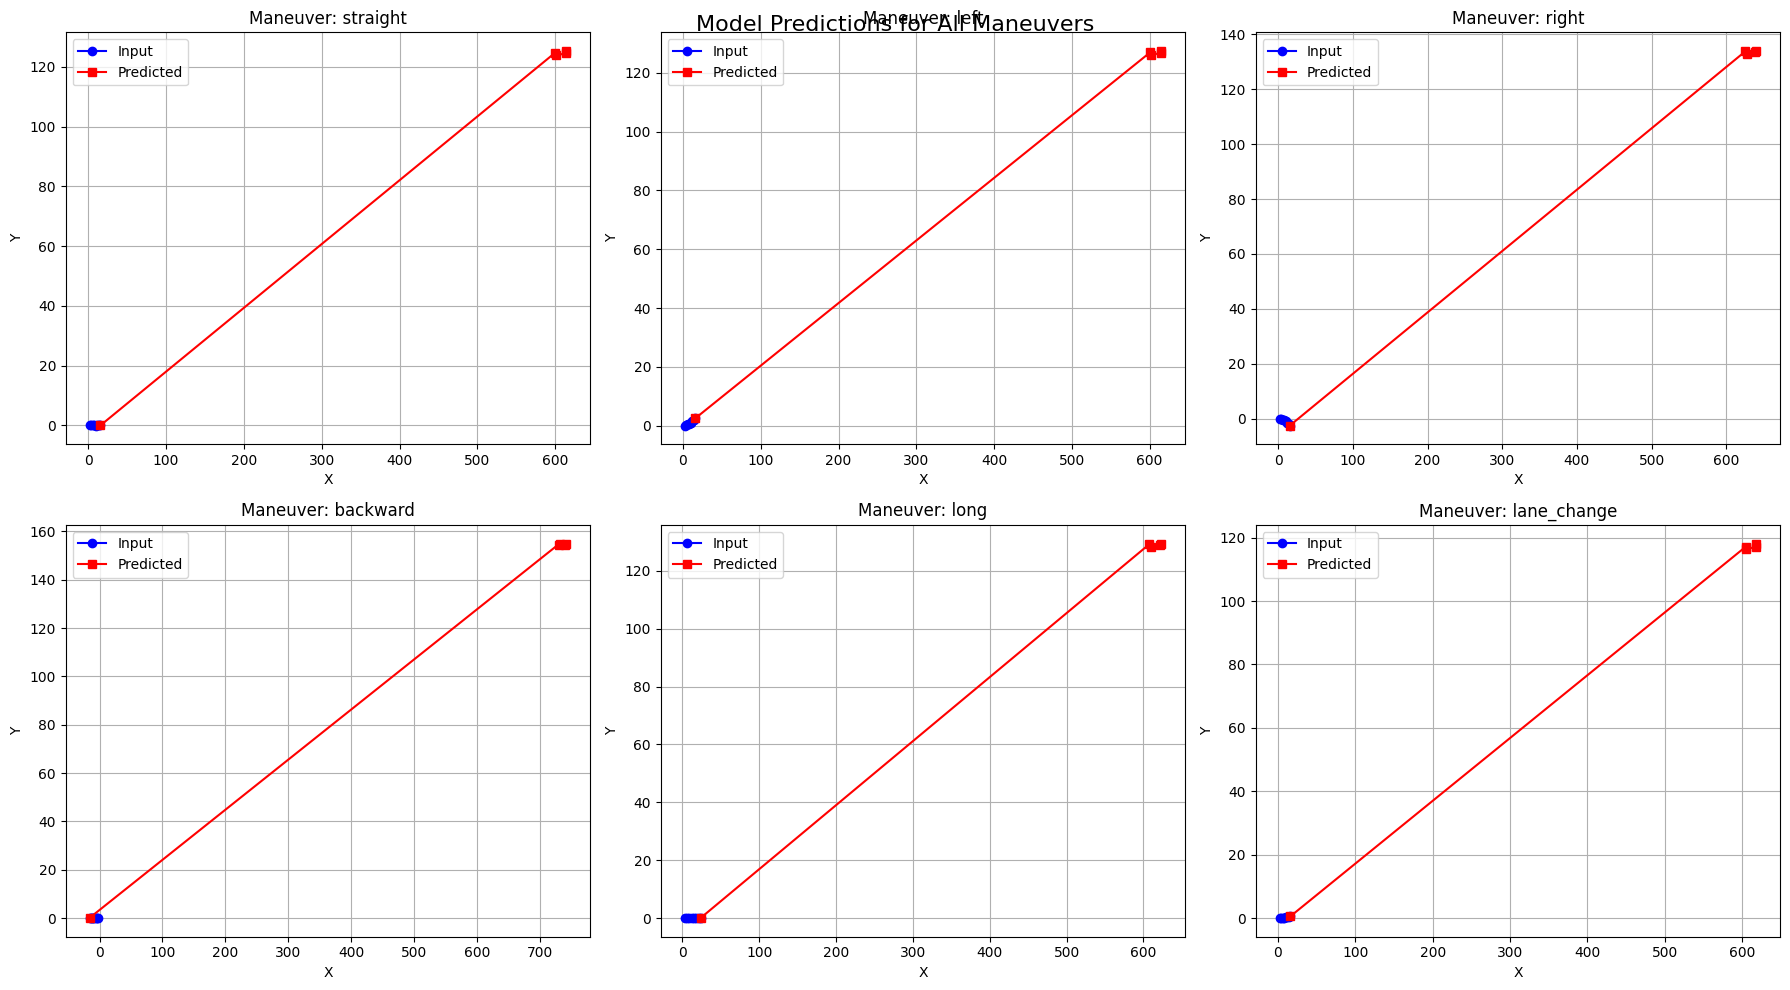

In [ ]:
# Test model prediction for all movement types
if trajectory_predictor is not None:
    maneuvers = ['straight', 'left', 'right', 'backward', 'long', 'lane_change']
    plt.figure(figsize=(18, 10))
    for idx, m in enumerate(maneuvers):
        traj = create_diverse_vehicle_trajectory(0, 0, 20, 0, length=trajectory_predictor.sequence_length, maneuver=m)
        try:
            pred = trajectory_predictor.predict_trajectory(traj)
        except Exception as e:
            print(f"Prediction failed for {m}: {e}")
            continue
        start_x, start_y = traj['Local_X'].iloc[-1], traj['Local_Y'].iloc[-1]
        pred_x = [start_x] + pred[:,0].tolist()
        pred_y = [start_y] + pred[:,1].tolist()
        plt.subplot(2, 3, idx+1)
        plt.plot(traj['Local_X'], traj['Local_Y'], 'b-o', label='Input')
        plt.plot(pred_x, pred_y, 'r-s', label='Predicted')
        plt.title(f'Maneuver: {m}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle('Model Predictions for All Maneuvers', fontsize=16)
    plt.show()
else:
    print('Train the model first to test predictions for all maneuvers.')

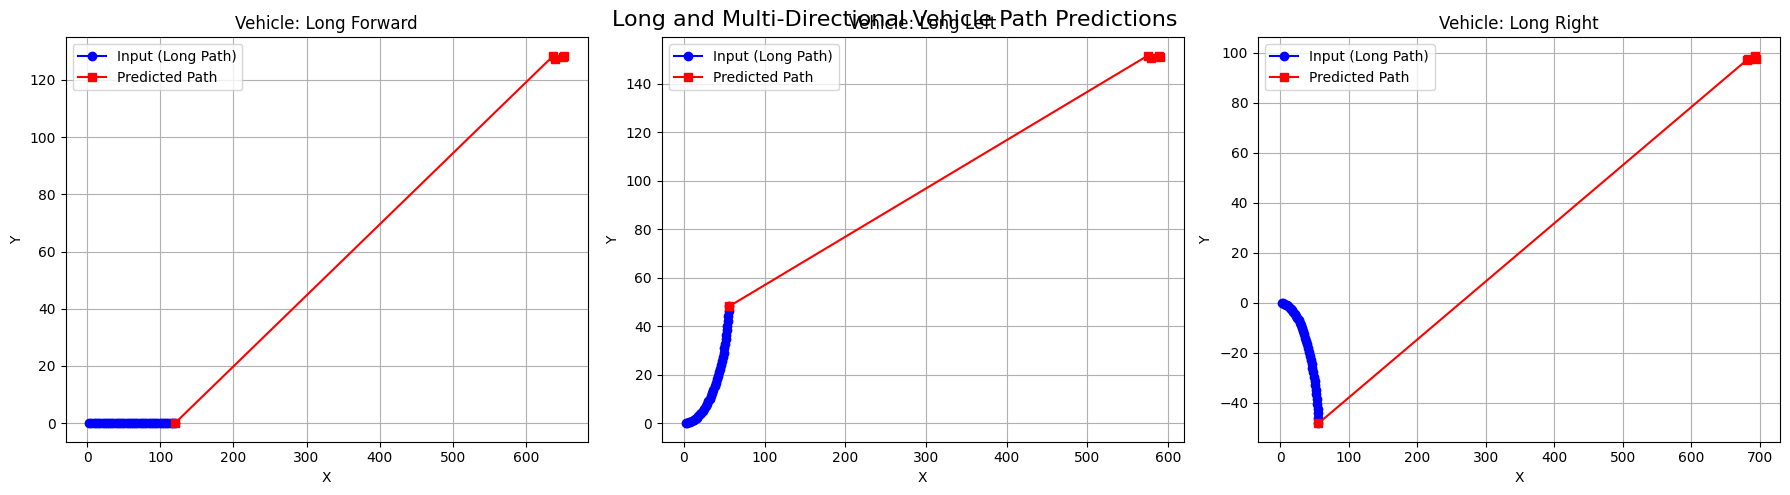

In [17]:
# Long and Multi-Directional Path Prediction Example
if trajectory_predictor is not None:
    plt.figure(figsize=(18, 5))
    maneuvers = [('long', 'Long Forward'), ('left', 'Long Left'), ('right', 'Long Right')]
    for idx, (m, title) in enumerate(maneuvers):
        # Generate a long trajectory for each maneuver
        traj = create_diverse_vehicle_trajectory(0, 0, 20, 0, length=40, maneuver=m)
        try:
            pred = trajectory_predictor.predict_trajectory(traj)
        except Exception as e:
            print(f"Prediction failed for {title}: {e}")
            continue
        start_x, start_y = traj['Local_X'].iloc[-1], traj['Local_Y'].iloc[-1]
        pred_x = [start_x] + pred[:,0].tolist()
        pred_y = [start_y] + pred[:,1].tolist()
        plt.subplot(1, 3, idx+1)
        plt.plot(traj['Local_X'], traj['Local_Y'], 'b-o', label='Input (Long Path)')
        plt.plot(pred_x, pred_y, 'r-s', label='Predicted Path')
        plt.title(f'Vehicle: {title}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle('Long and Multi-Directional Vehicle Path Predictions', fontsize=16)
    plt.show()
else:
    print('Train the model first to test long and multi-directional path predictions.')